In [1]:
import h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Fit log-polynomial to Websky radio galaxies

The websky team released catalogs of radio galaxies with their coordinates and with their flux and polarized flux at frequencies between ~20 and ~900 GHz.

The purpose of this notebook is to inspect those catalogs and compute fitting coefficients that can reasonably approximage the flux and polarized flux.

In [2]:
%load_ext jupyter_ai

/global/common/software/cmb/zonca/conda/pycmb/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cd /global/cfs/cdirs/sobs/www/users/Radio_WebSky/matched_catalogs_2

/global/cfs/cdirs/sobs/www/users/Radio_WebSky/matched_catalogs_2


In [4]:
%ls 

catalog_100.0.h5  catalog_232.0.h5  catalog_353.0.h5  catalog_643.0.h5
catalog_111.0.h5  catalog_24.5.h5   catalog_375.0.h5  catalog_67.8.h5
catalog_129.0.h5  catalog_256.0.h5  catalog_409.0.h5  catalog_70.0.h5
catalog_143.0.h5  catalog_27.3.h5   catalog_41.7.h5   catalog_729.0.h5
catalog_153.0.h5  catalog_275.0.h5  catalog_44.0.h5   catalog_73.7.h5
catalog_164.0.h5  catalog_294.0.h5  catalog_467.0.h5  catalog_79.6.h5
catalog_18.7.h5   catalog_30.0.h5   catalog_47.4.h5   catalog_817.0.h5
catalog_189.0.h5  catalog_306.0.h5  catalog_525.0.h5  catalog_857.0.h5
catalog_21.6.h5   catalog_314.0.h5  catalog_545.0.h5  catalog_90.2.h5
catalog_210.0.h5  catalog_340.0.h5  catalog_584.0.h5  catalog_906.0.h5
catalog_217.0.h5  catalog_35.9.h5   catalog_63.9.h5


In [5]:
cat = h5py.File("catalog_217.0.h5", "r")

In [6]:
cat.keys()

<KeysViewHDF5 ['flux', 'phi', 'polarized flux', 'theta']>

In [7]:
for k,v in cat.items():
    print(k, v[:3])

flux [1.83476104e-07 3.15539722e-07 2.32608542e-07]
phi [3.22861886 3.22861886 3.22861886]
polarized flux [2.57622279e-09 7.17693061e-09 1.11259690e-09]
theta [1.64009452 1.64009452 1.64009452]


In [8]:
freqs = ["18.7", "24.5", "44.0", "70.0", "100.0", "143.0", "217.0", "353.0", "545.0", "643.0", "729.0", "857.0", "906.0"] 

In [9]:
n = 20

indices = {}

for freq in freqs:
    print(freq)
    cat = h5py.File(f"catalog_{freq}.h5", "r")
    indices[freq] = np.sort(np.argpartition(cat["flux"], -n)[-n:])

18.7
24.5
44.0
70.0
100.0
143.0
217.0
353.0
545.0
643.0
729.0
857.0
906.0


In [10]:
all_indices = set()
for v in indices.values():
    all_indices.update(v)

In [11]:
len(all_indices)

43

In [12]:
%%ai gemini:gemini-pro -f code

convert the all_indices set in a sorted array

In [ ]:
def all_indices(nums, target):
  return [i for i, x in enumerate(nums) if x == target]

In [13]:
all_indices = sorted(all_indices)

In [14]:
all_indices = np.array(sorted(all_indices))

## Extract brightest sources from catalogs

In [15]:
import pandas as pd
import xarray as xr

In [16]:
cat.keys()

<KeysViewHDF5 ['flux', 'phi', 'polarized flux', 'theta']>

In [17]:
columns = ["theta", "phi", "flux", "polarized flux"]

In [18]:
import xarray as xr

flux = xr.DataArray(
    data=np.zeros((len(all_indices), len(freqs)), dtype=np.float64),
    coords={"index": all_indices, "freq": list(map(float,freqs))},
    name="flux",
)

In [19]:
polarized_flux = flux.copy()

In [20]:
sources_xr = xr.Dataset({"flux":flux,"polarized_flux":polarized_flux})

In [21]:
for freq in freqs:
    print(freq)
    cat = h5py.File(f"catalog_{freq}.h5", "r")
    # Get the indices of the 10 largest values
    for column in ["flux", "polarized_flux"]:
        sources_xr[column].loc[dict(index=all_indices, freq=float(freq))] = cat[column.replace("_"," ")][all_indices] 

18.7
24.5
44.0
70.0
100.0
143.0
217.0
353.0
545.0
643.0
729.0
857.0
906.0


In [22]:
sources_xr

<xarray.Dataset> Size: 9kB
Dimensions:         (index: 43, freq: 13)
Coordinates:
  * index           (index) int64 344B 27897657 157969580 ... 281569233
  * freq            (freq) float64 104B 18.7 24.5 44.0 ... 729.0 857.0 906.0
Data variables:
    flux            (index, freq) float64 4kB 133.4 102.8 74.18 ... 2.221 2.221
    polarized_flux  (index, freq) float64 4kB 2.656 2.976 ... 0.121 0.05634

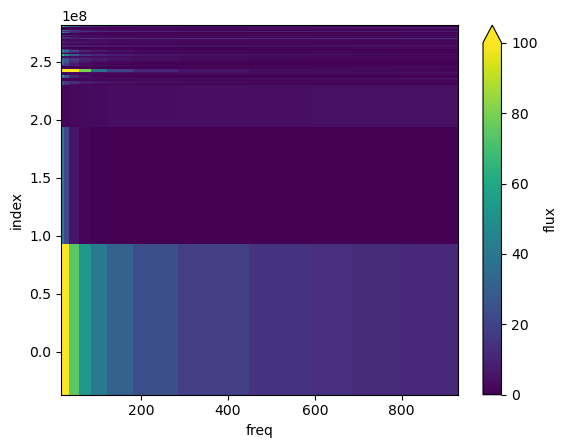

In [23]:
sources_xr.flux.plot(vmin=0, vmax=100)

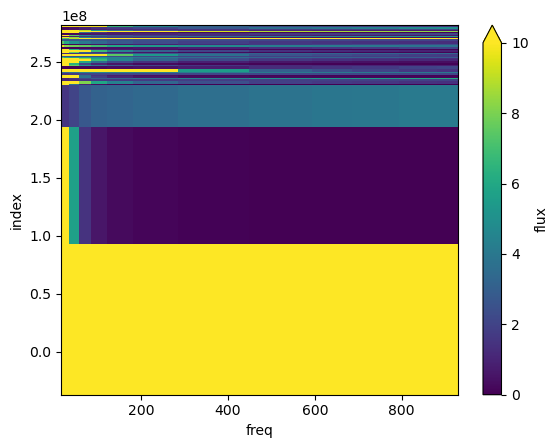

In [24]:
sources_xr.flux.plot(vmin=0, vmax=10)

In [25]:
#%%ai gemini:gemini-pro -f code
#
#    xarray DataArray plot only markers no line

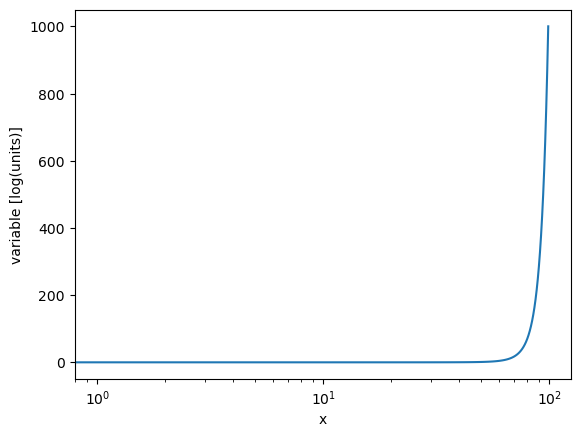

In [33]:
import numpy as np
import xarray as xr

# Create a dataset with a variable to be plotted on a log scale
data = xr.Dataset(
    {
        "variable": xr.DataArray(
            np.logspace(-3, 3, 100),
            dims=["x"],
            attrs={"units": "log(units)"},
        )
    }
)

# Plot the variable on a log scale
data["variable"].plot.line(xscale="log")

In [34]:
import xarray as xr

# Create a Dataset with a single dimension (time)
ds = xr.Dataset({"temperature": (["time"], [0, 1, 2])})

# Add a non-coordinate dimension (depth)
ds = ds.expand_dims({"phi": 3})

/tmp/ipykernel_1111920/214637953.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


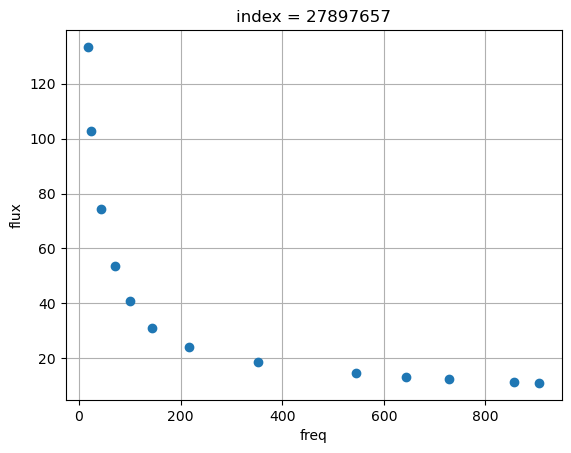

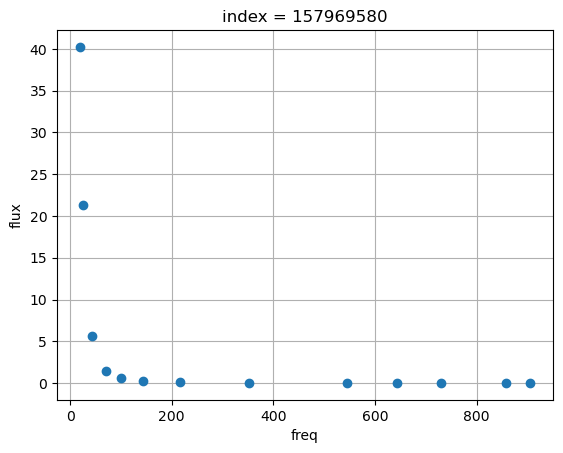

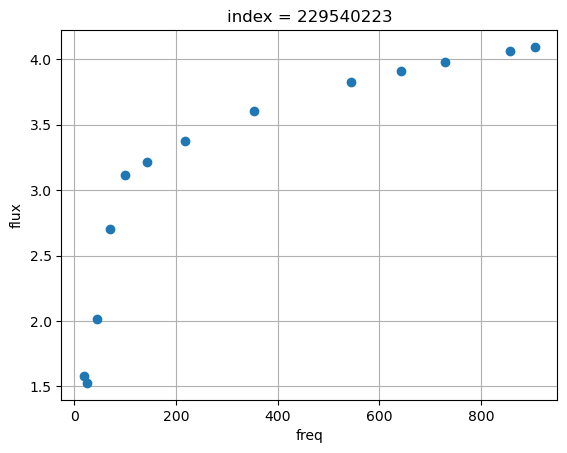

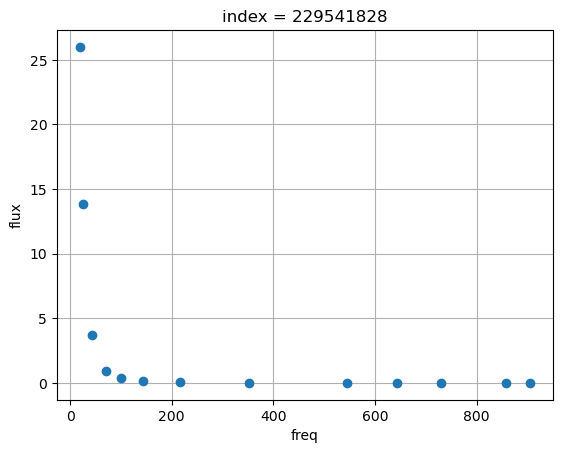

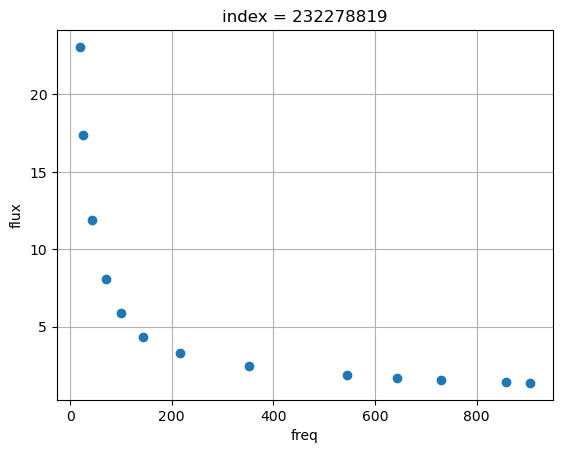

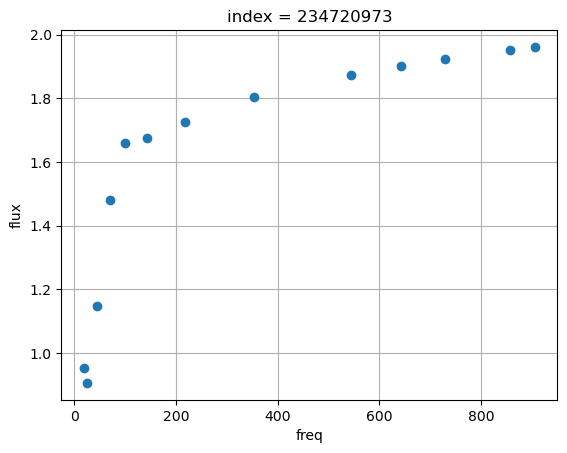

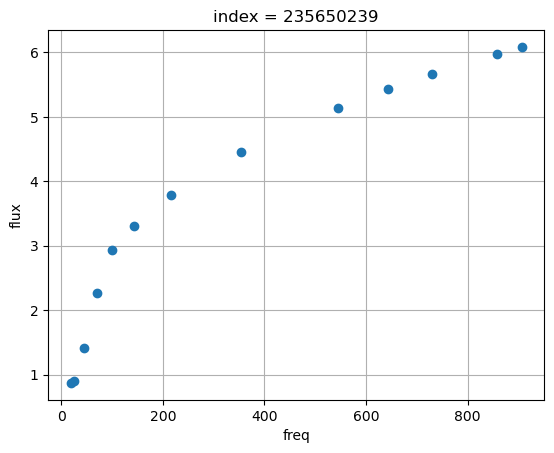

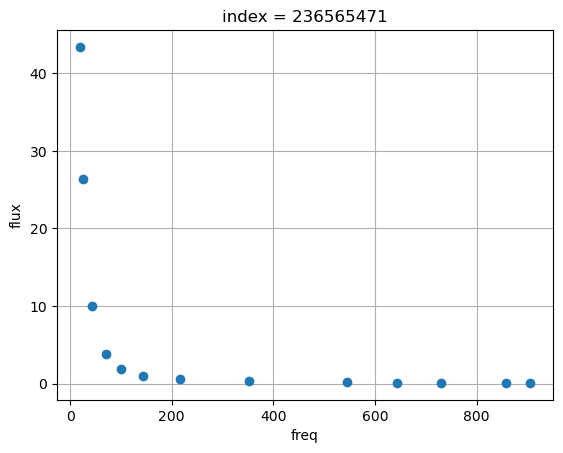

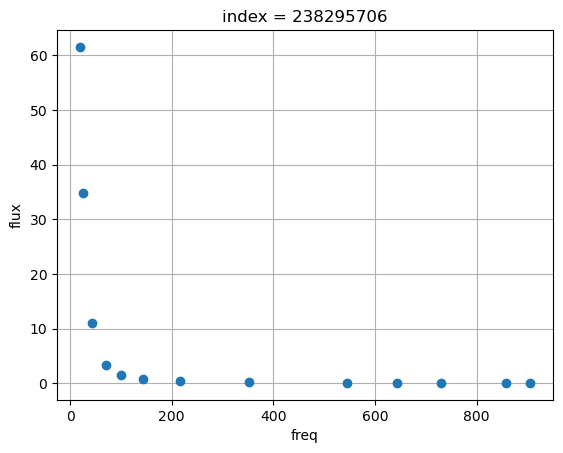

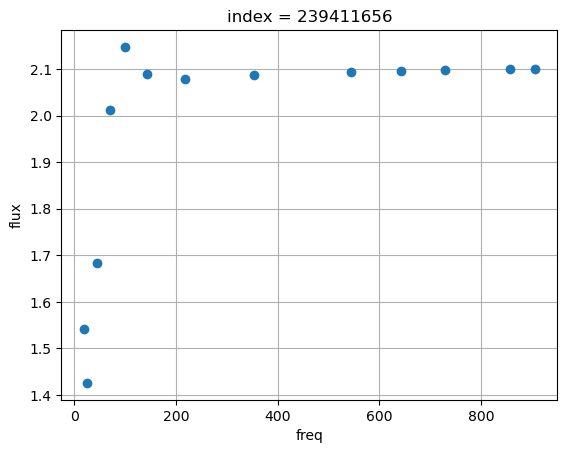

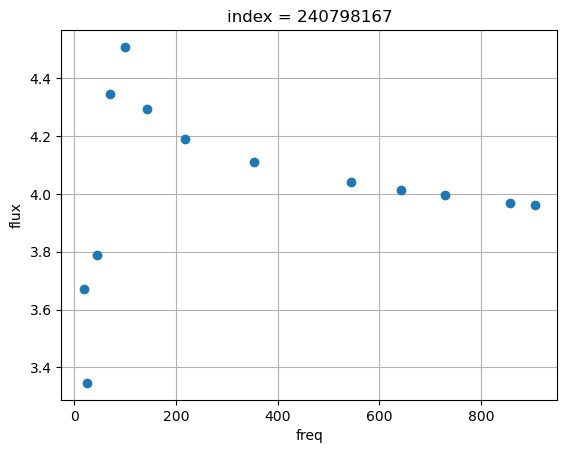

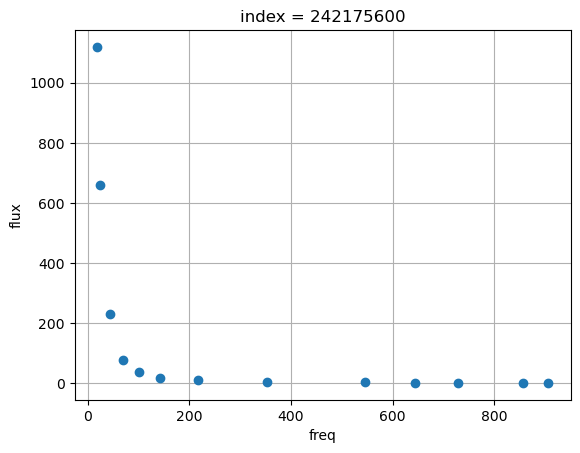

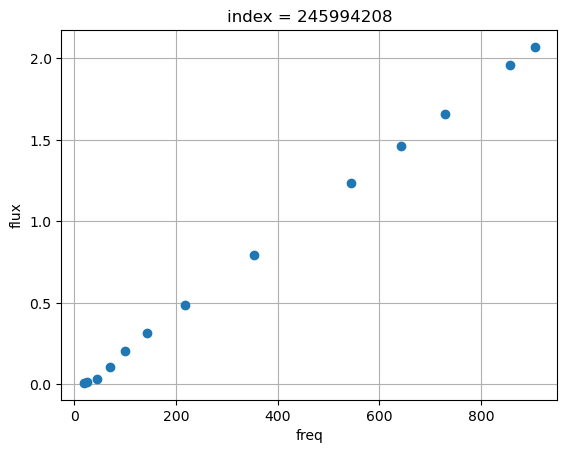

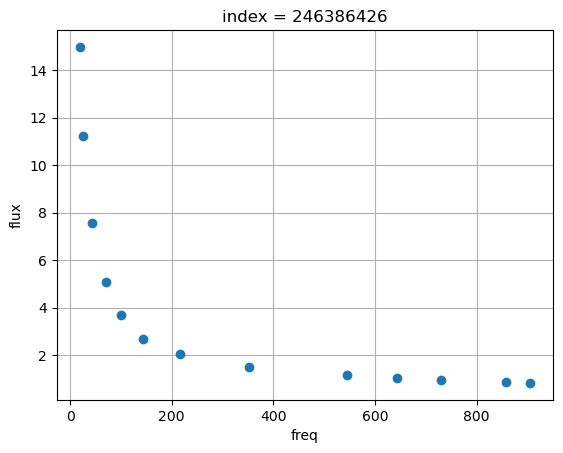

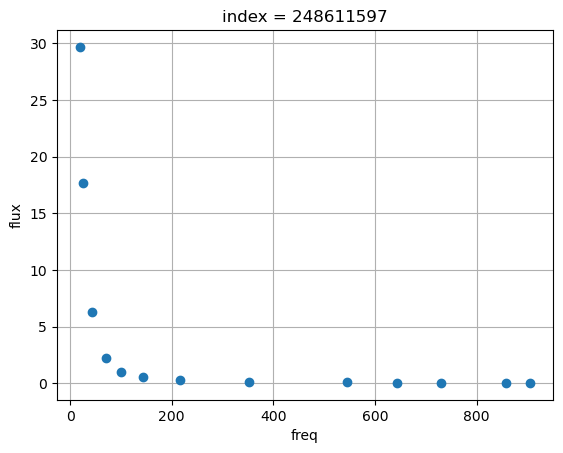

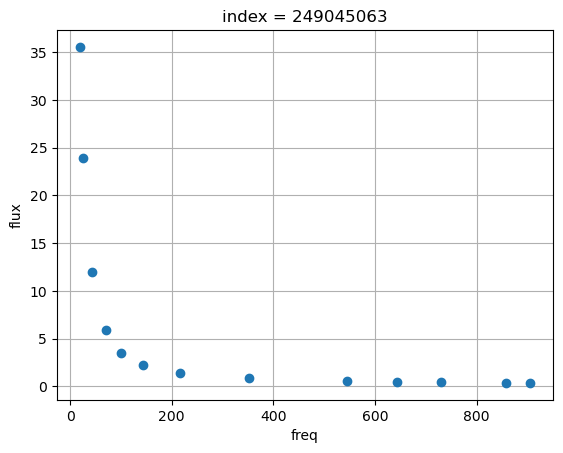

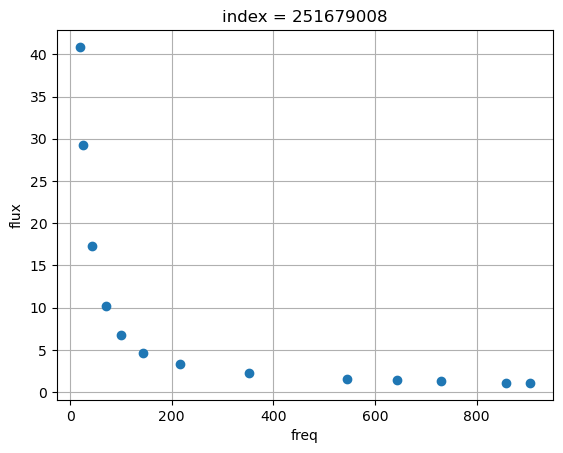

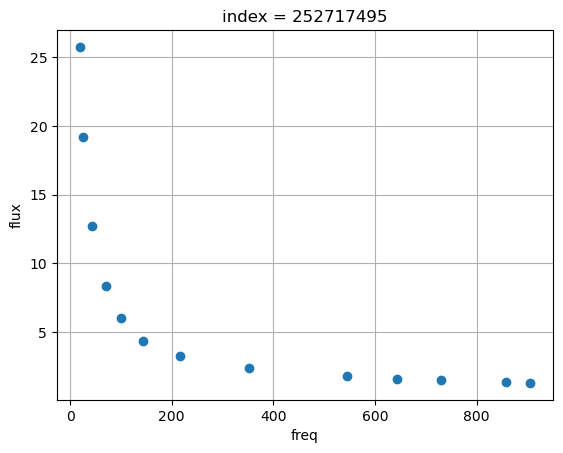

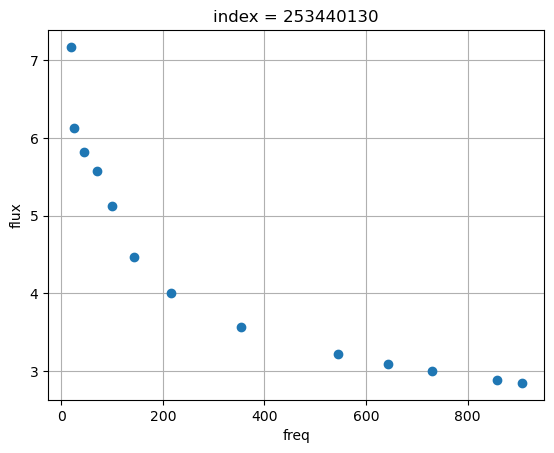

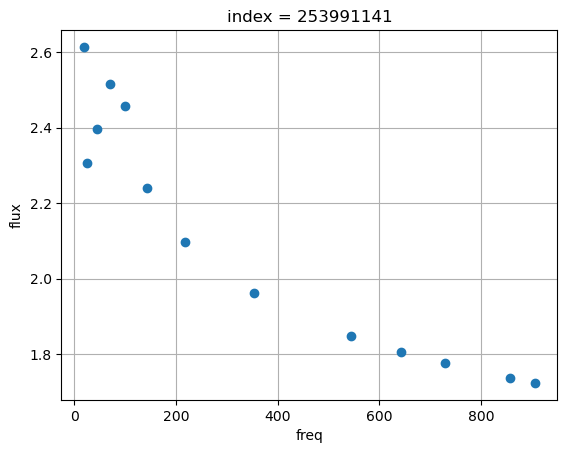

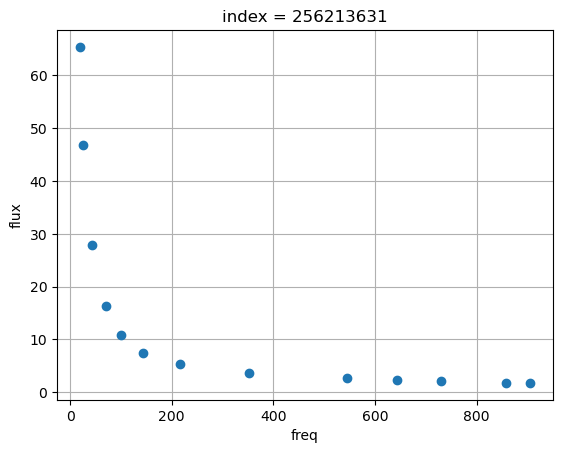

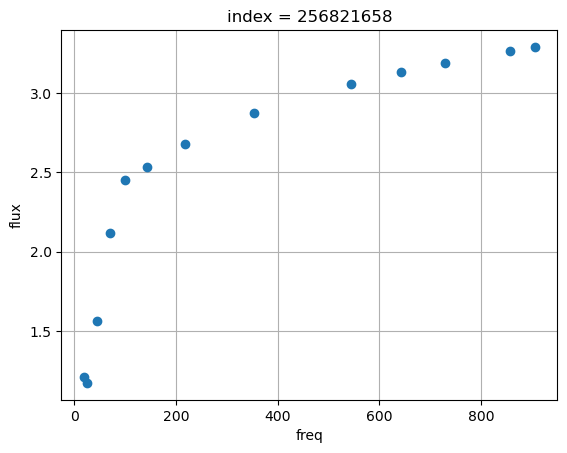

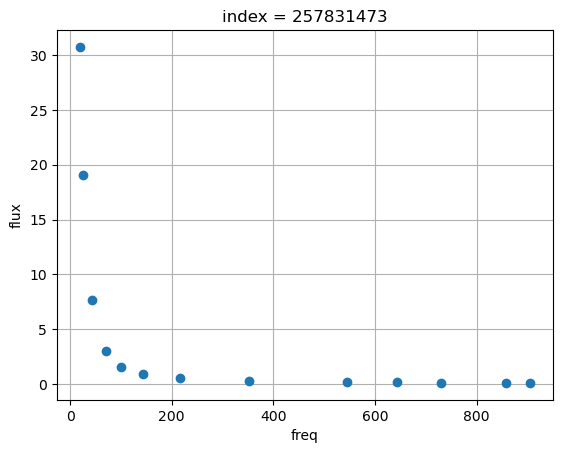

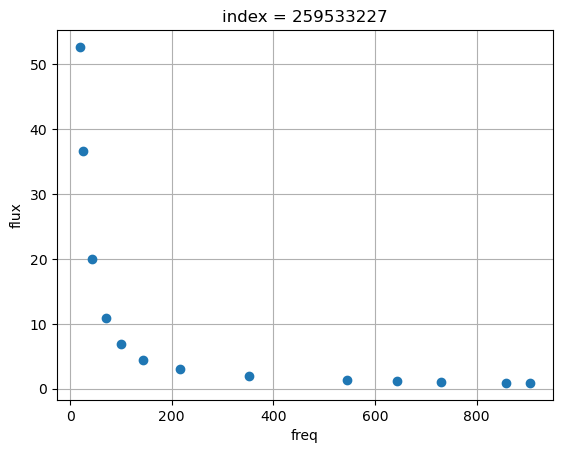

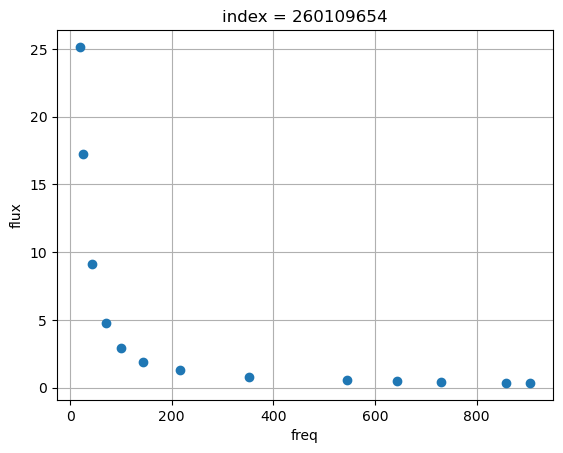

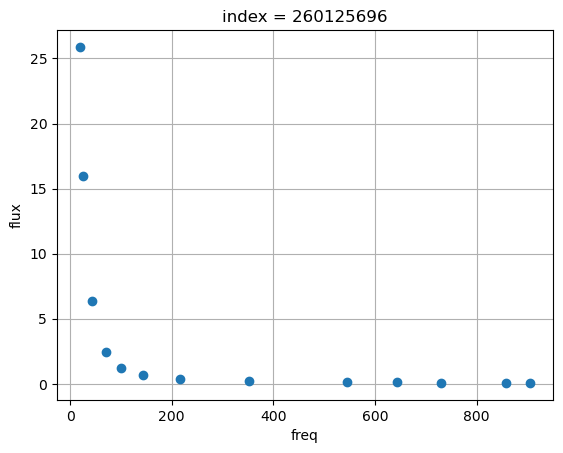

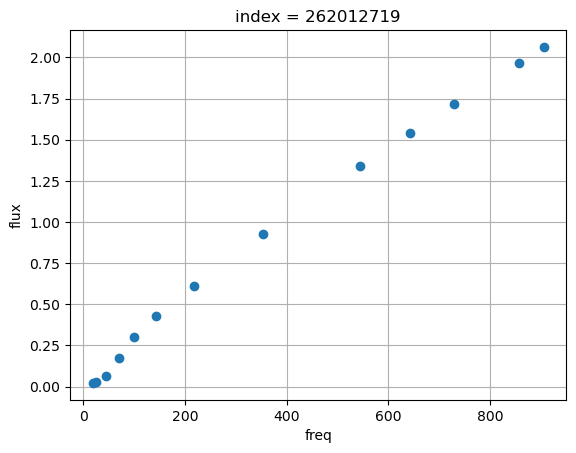

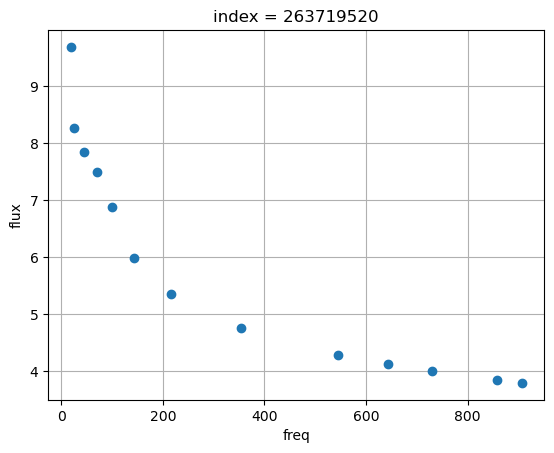

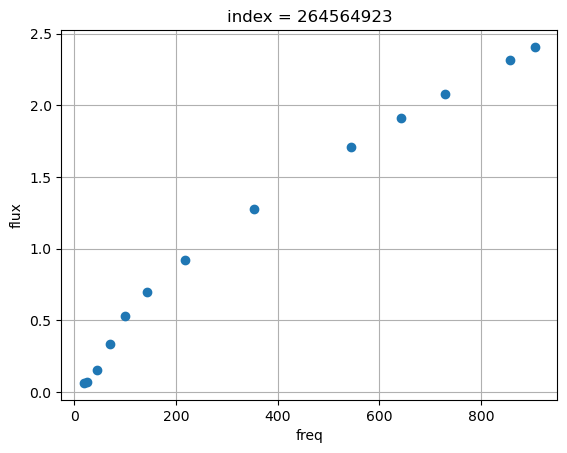

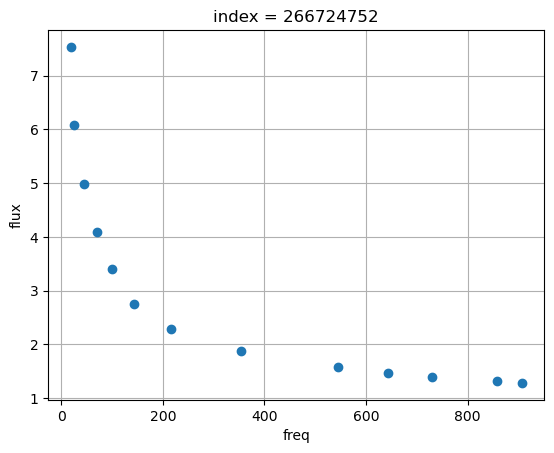

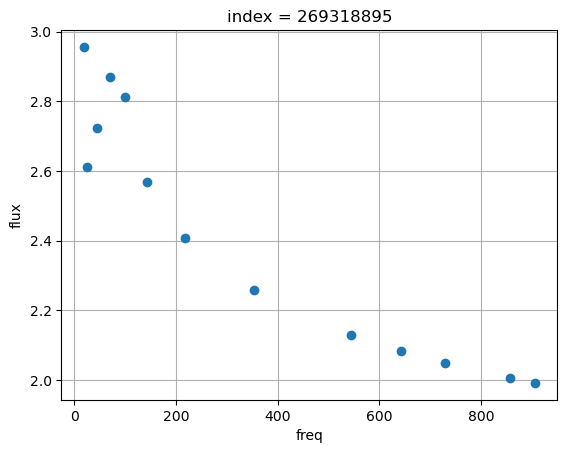

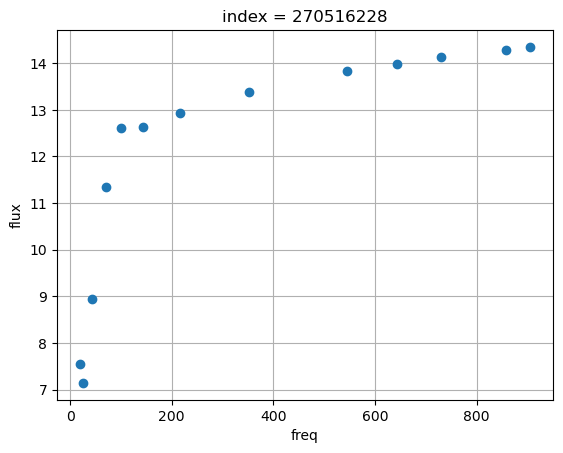

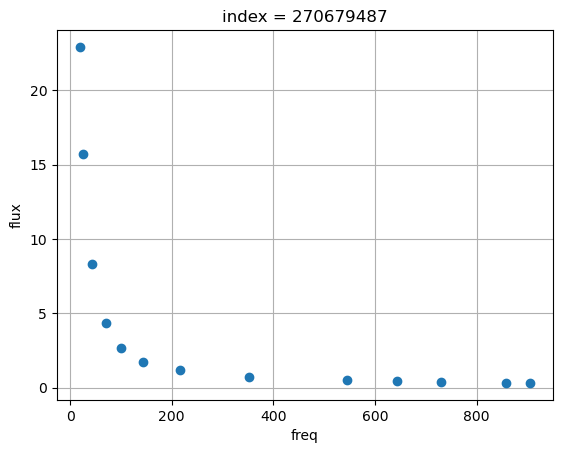

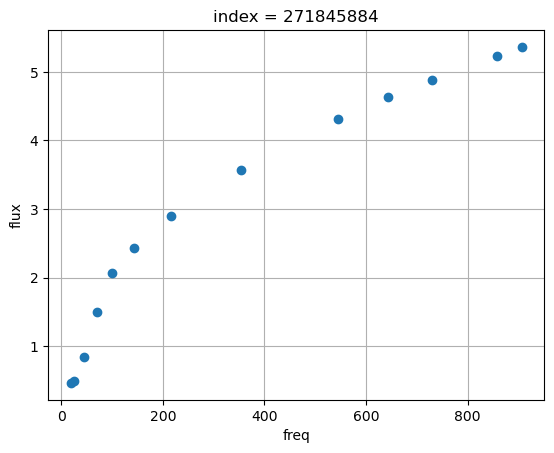

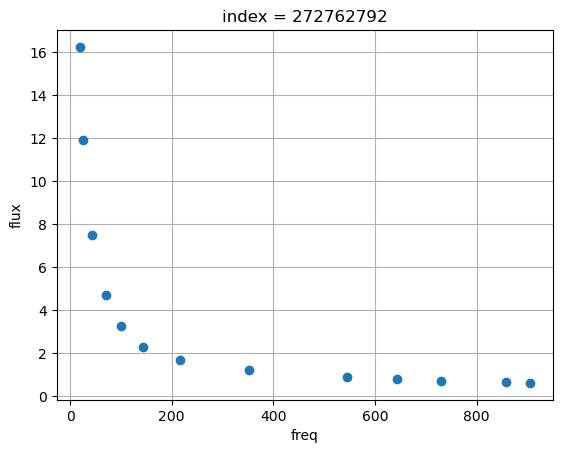

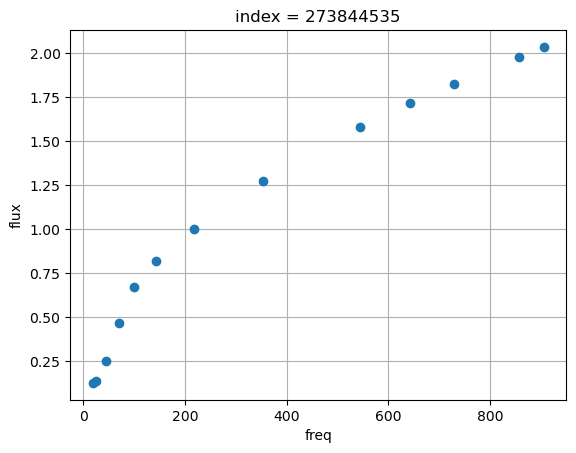

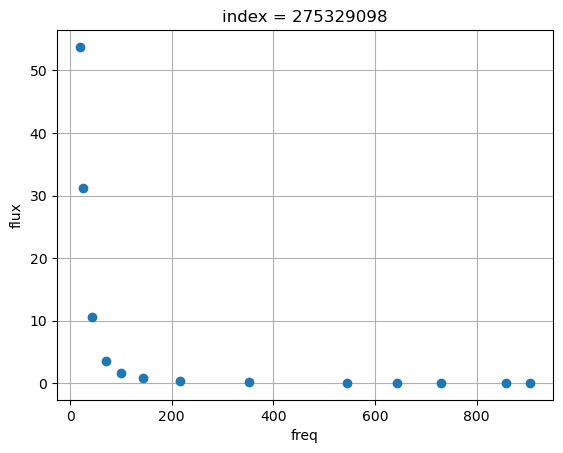

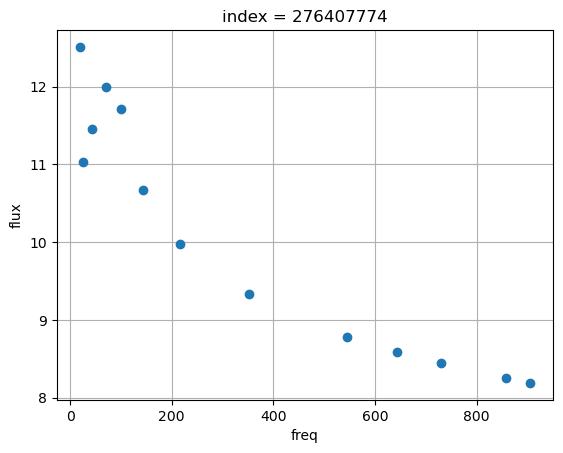

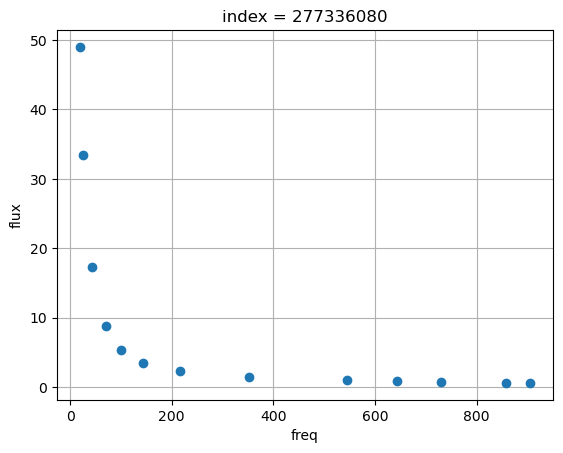

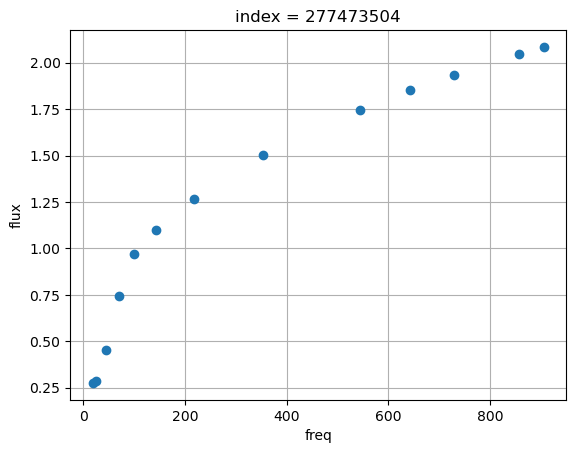

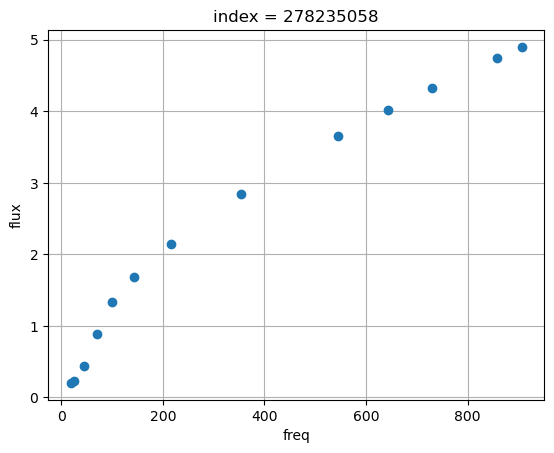

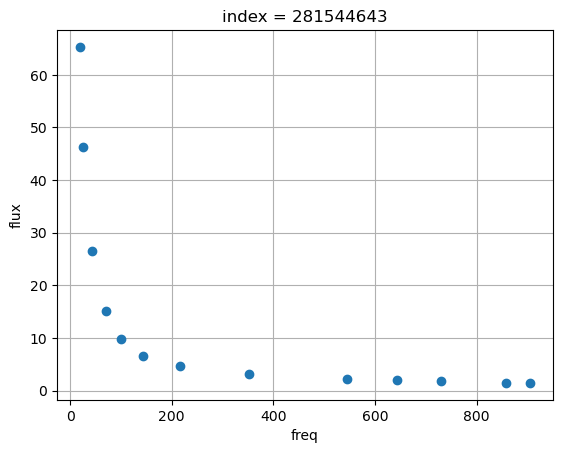

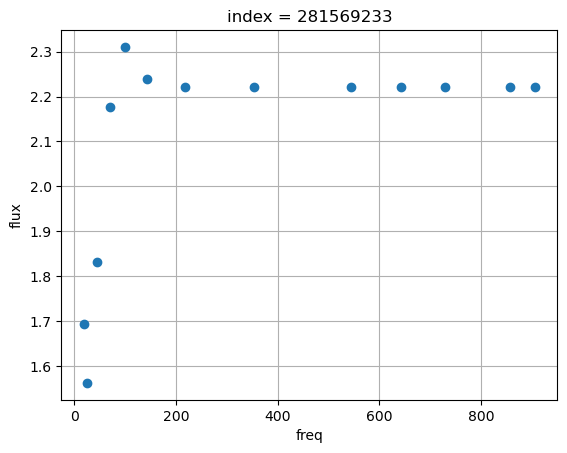

In [35]:
for s in all_indices:
    plt.figure()
    sources_xr.flux.sel(index=s).plot(marker="o", linestyle='none')#, xscale="log")
    plt.grid();

In [36]:
from scipy.optimize import curve_fit

In [37]:
def model(freq, a, b, c, d, e):
    log_freq = np.log(freq)
    return a + b * log_freq + c * log_freq**2 + d * log_freq **3 + e * log_freq **4

In [40]:
#%%ai gemini:gemini-pro -f code
#
#    add new data variable xarray Dataset

In [41]:
sources_xr['logpolycoef'] = xr.DataArray(np.zeros((len(all_indices), 5), dtype=np.float64),
        dims=["index", "power"], coords={"power":np.arange(5)})

In [42]:
sources_xr

<xarray.Dataset> Size: 11kB
Dimensions:         (index: 43, freq: 13, power: 5)
Coordinates:
  * index           (index) int64 344B 27897657 157969580 ... 281569233
  * freq            (freq) float64 104B 18.7 24.5 44.0 ... 729.0 857.0 906.0
  * power           (power) int64 40B 0 1 2 3 4
Data variables:
    flux            (index, freq) float64 4kB 133.4 102.8 74.18 ... 2.221 2.221
    polarized_flux  (index, freq) float64 4kB 2.656 2.976 ... 0.121 0.05634
    logpolycoef     (index, power) float64 2kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [43]:
for s in all_indices:
    sources_xr["logpolycoef"].loc[dict(index=s)], cov = curve_fit(model, sources_xr.coords["freq"], sources_xr.flux.sel(index=s))

In [44]:
sources_xr.coords["freq"]

<xarray.DataArray 'freq' (freq: 13)> Size: 104B
array([ 18.7,  24.5,  44. ,  70. , 100. , 143. , 217. , 353. , 545. , 643. ,
       729. , 857. , 906. ])
Coordinates:
  * freq     (freq) float64 104B 18.7 24.5 44.0 70.0 ... 643.0 729.0 857.0 906.0

In [47]:
len(all_indices)

43

/tmp/ipykernel_1111920/2780439640.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


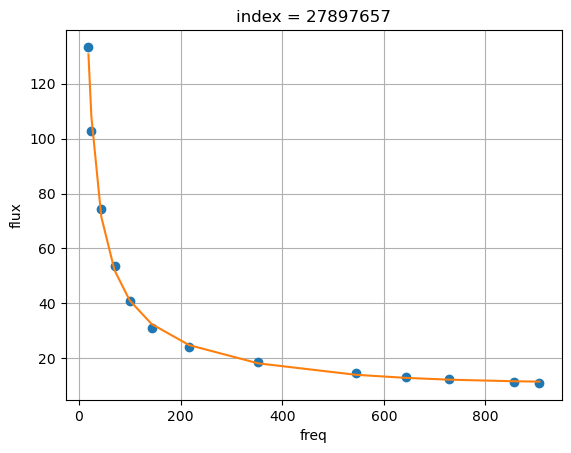

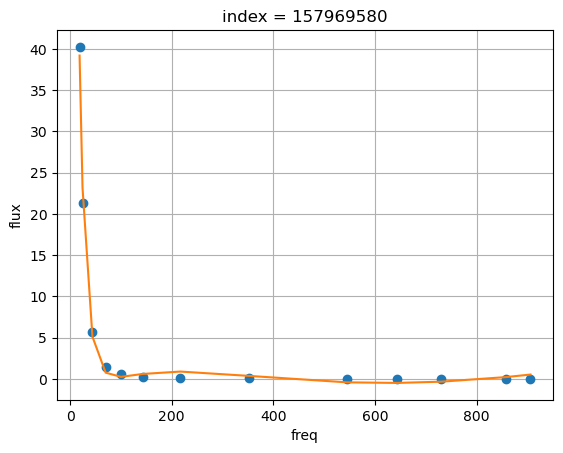

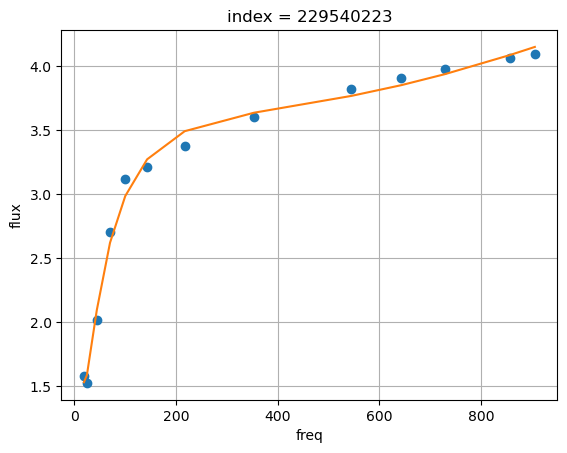

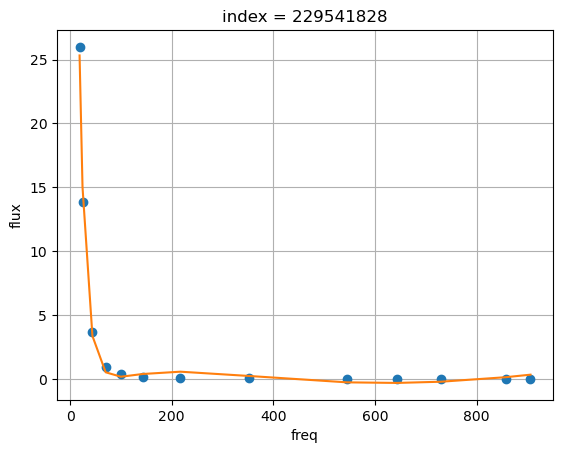

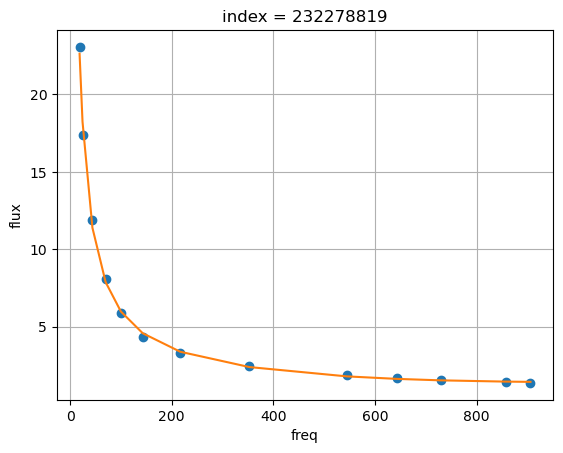

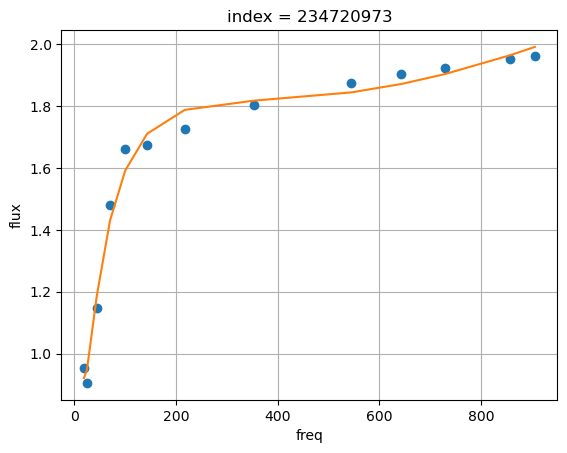

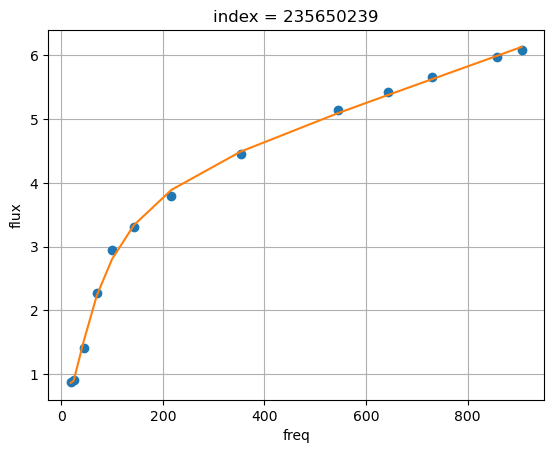

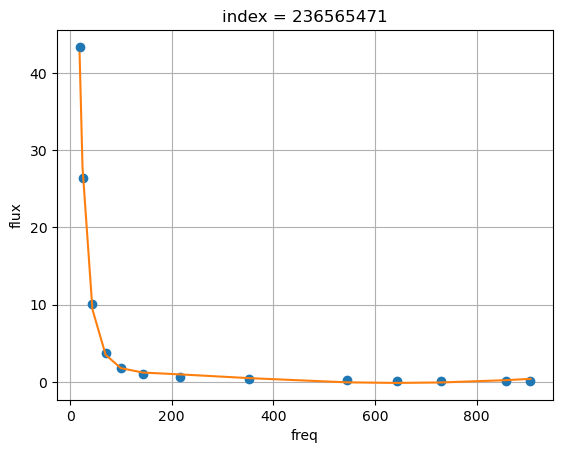

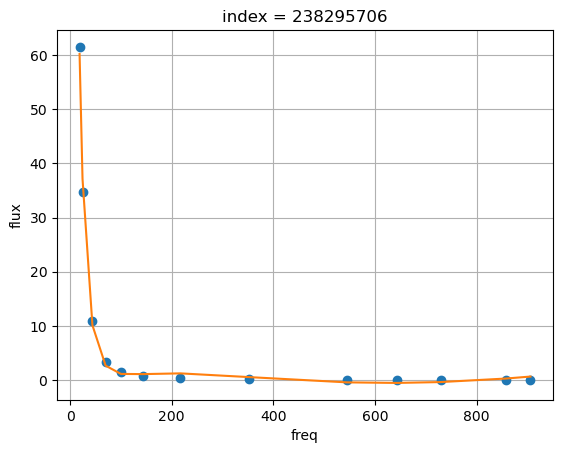

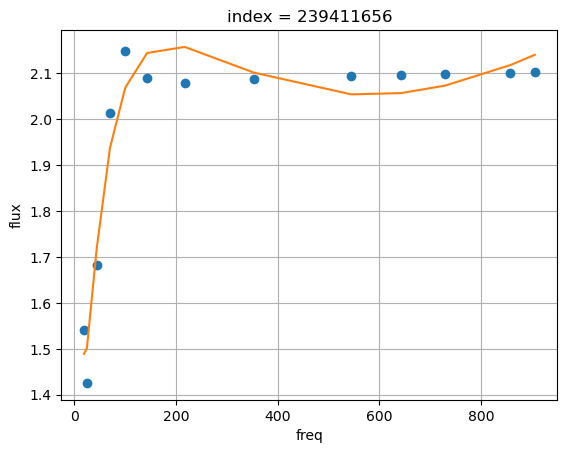

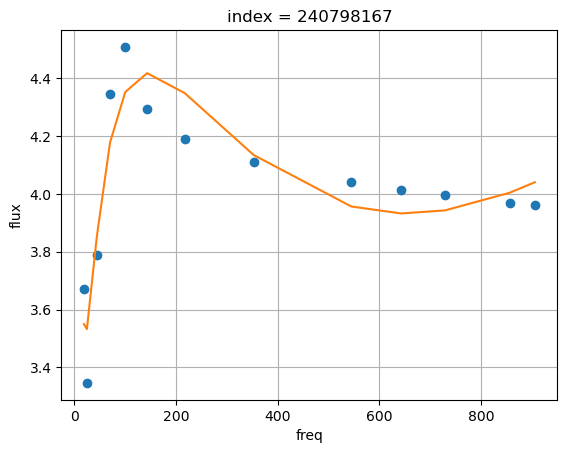

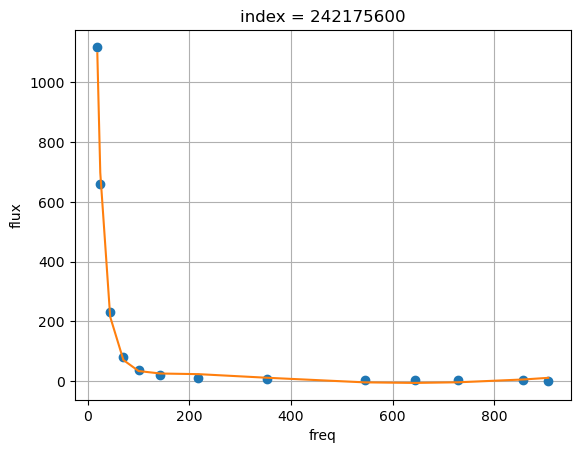

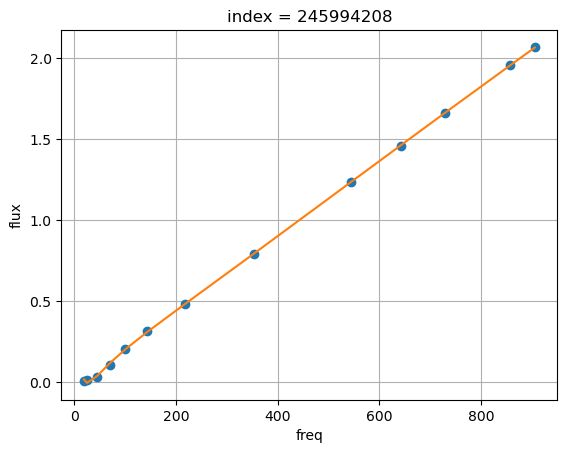

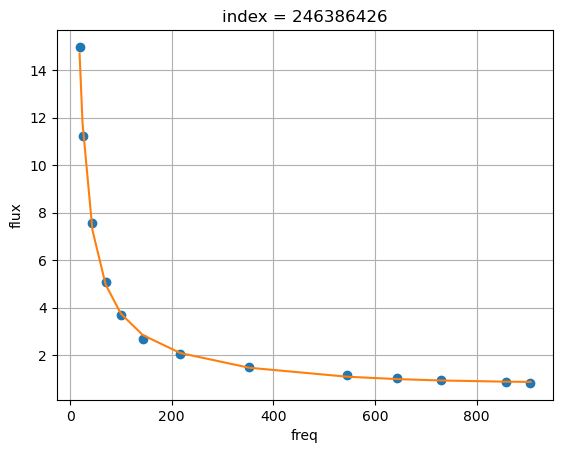

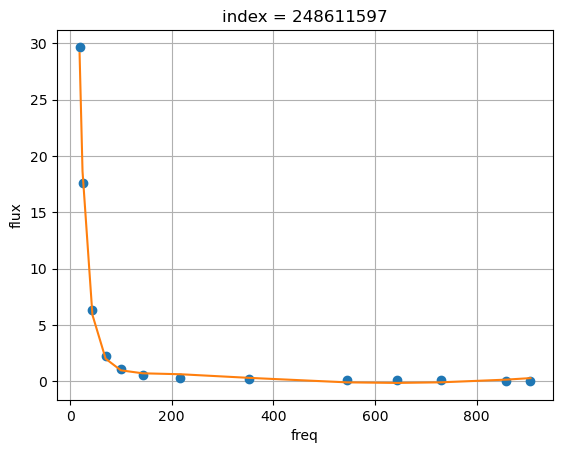

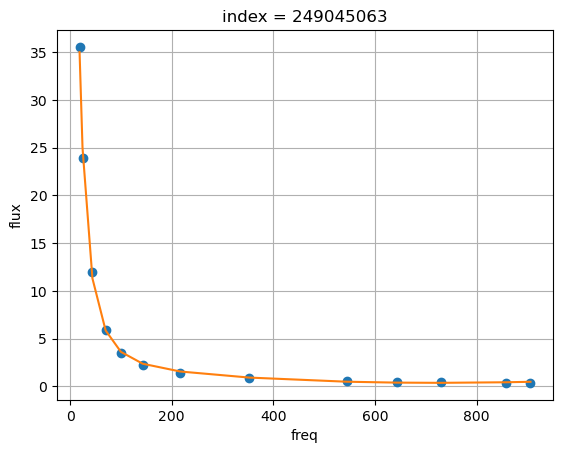

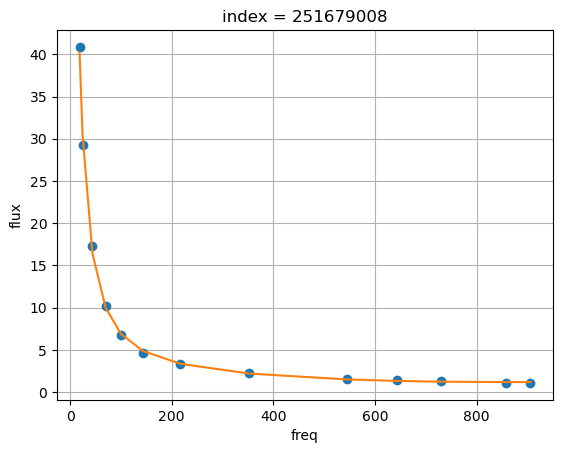

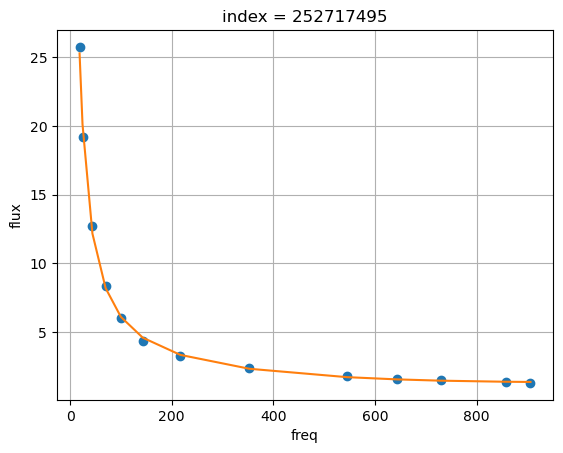

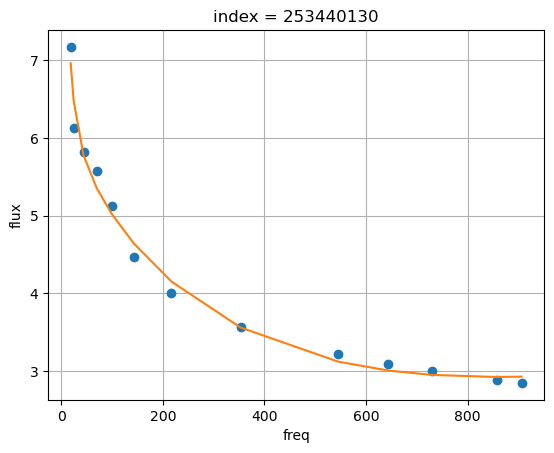

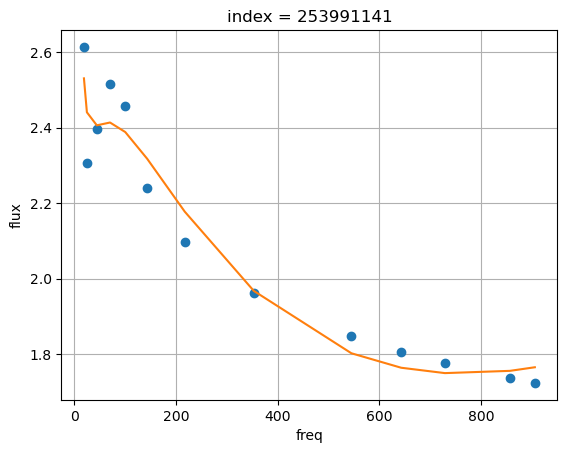

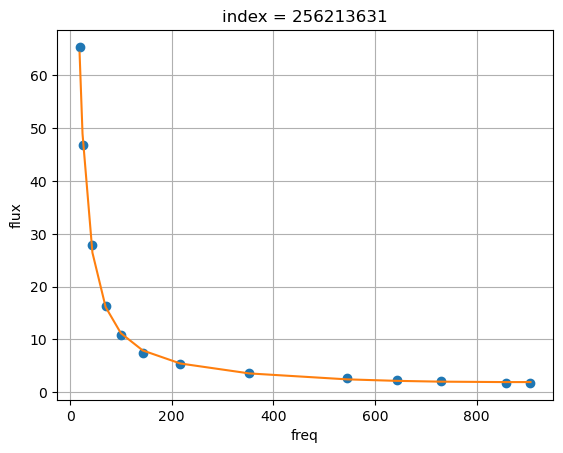

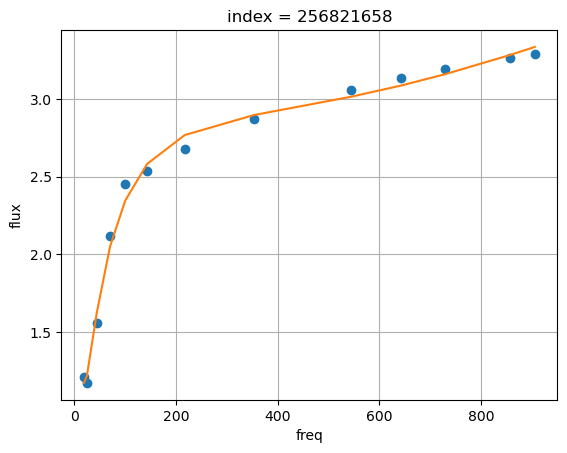

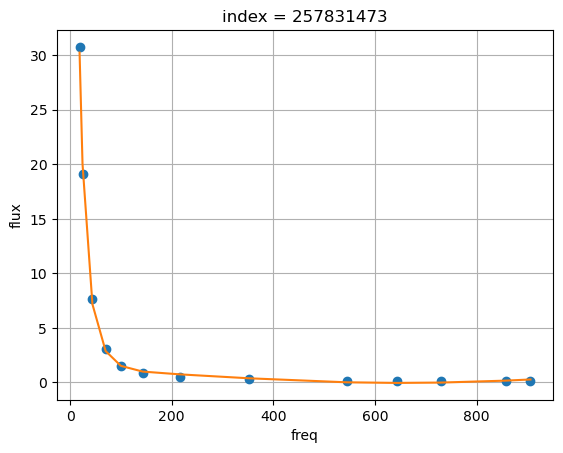

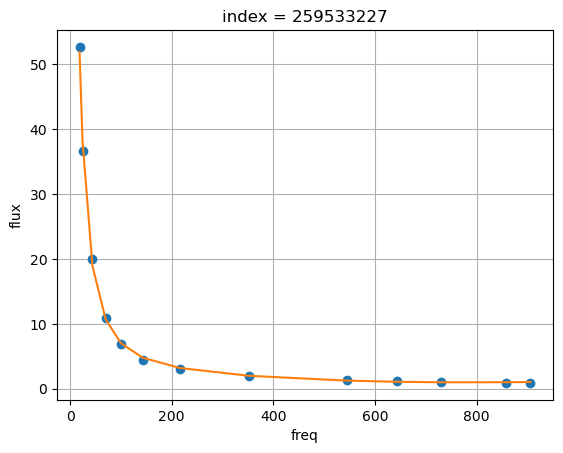

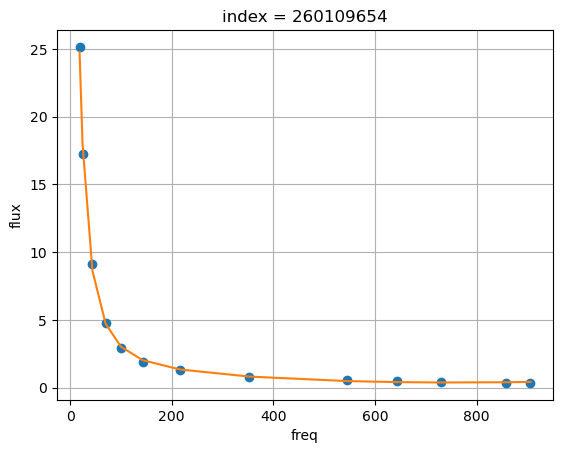

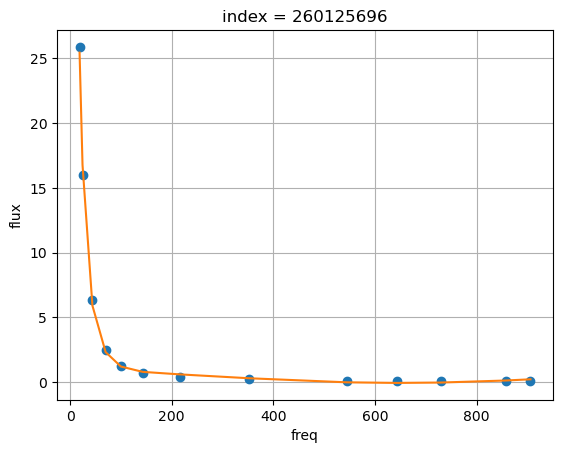

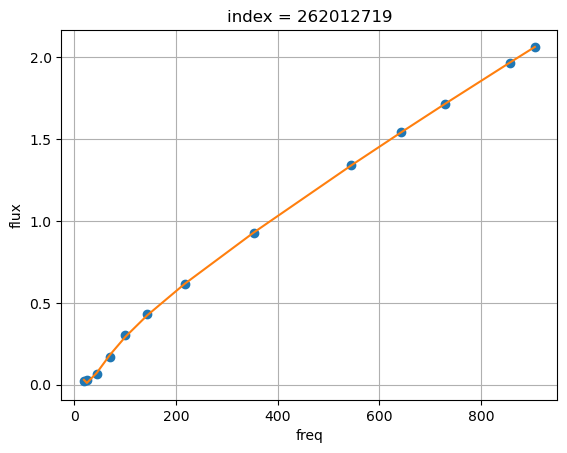

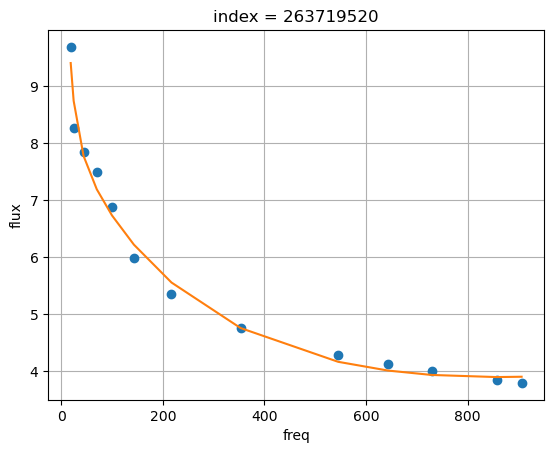

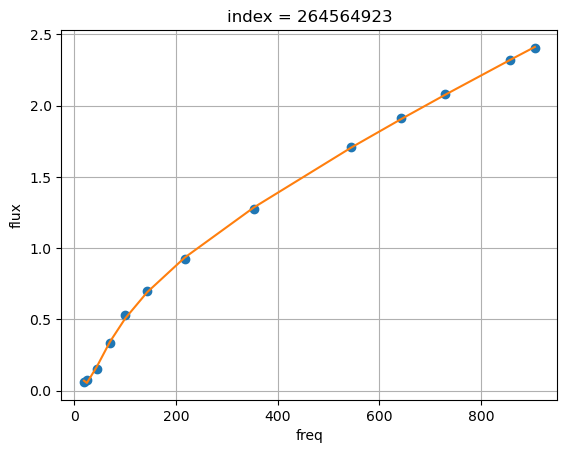

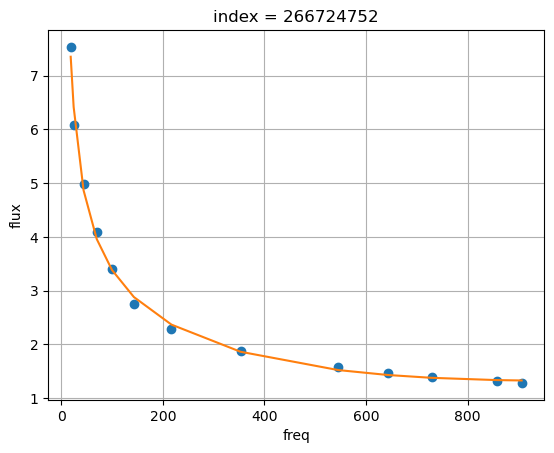

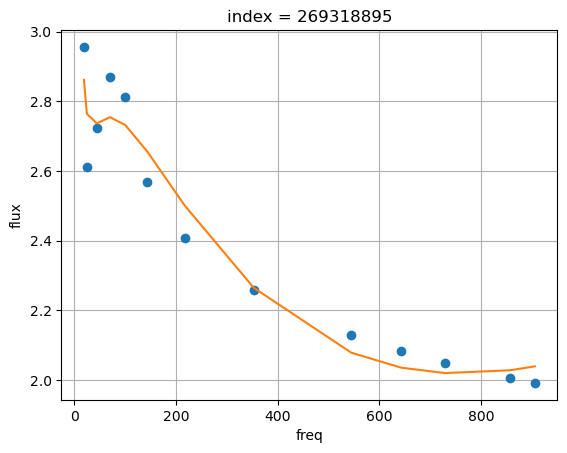

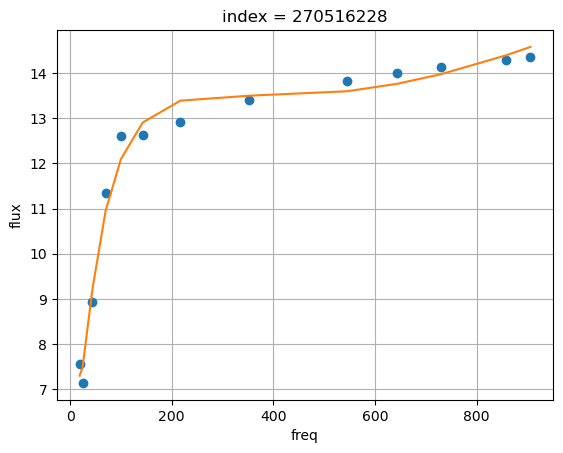

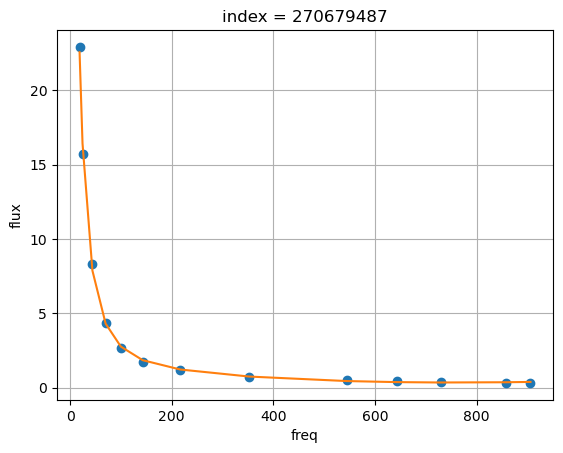

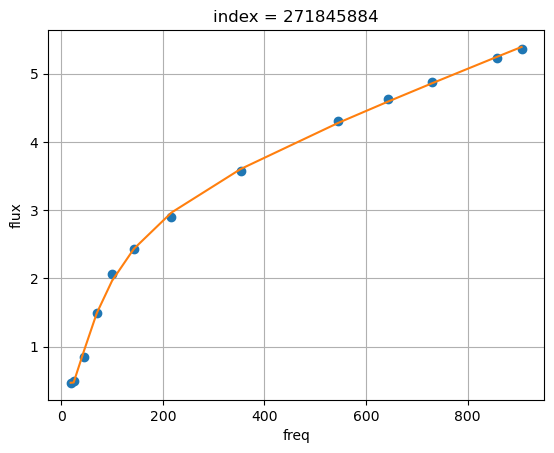

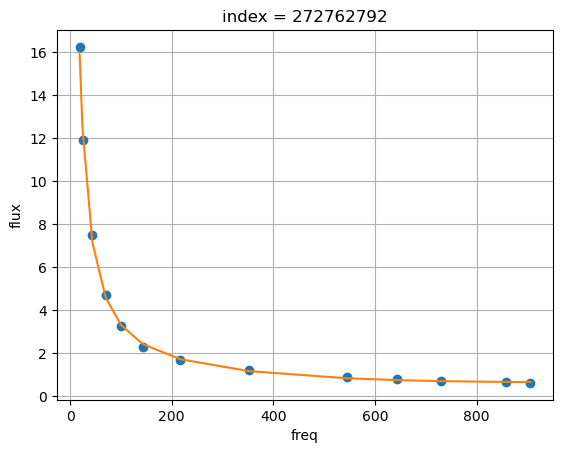

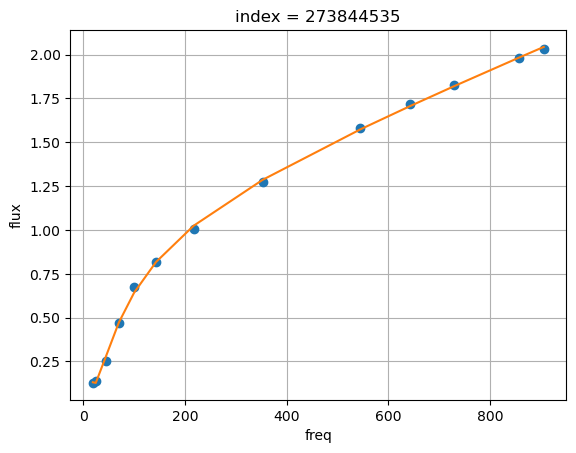

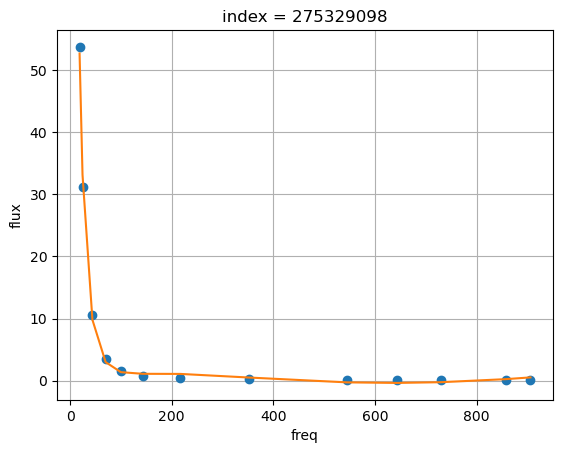

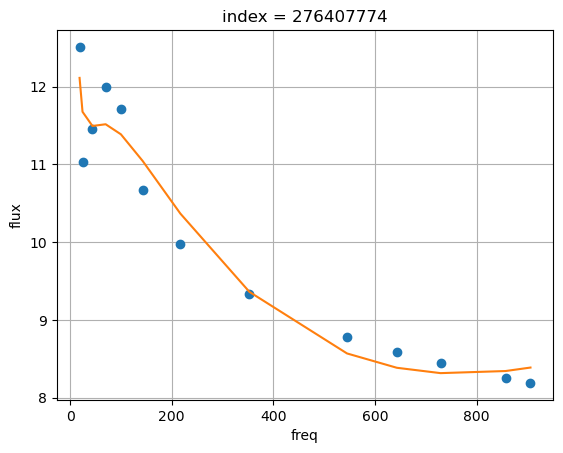

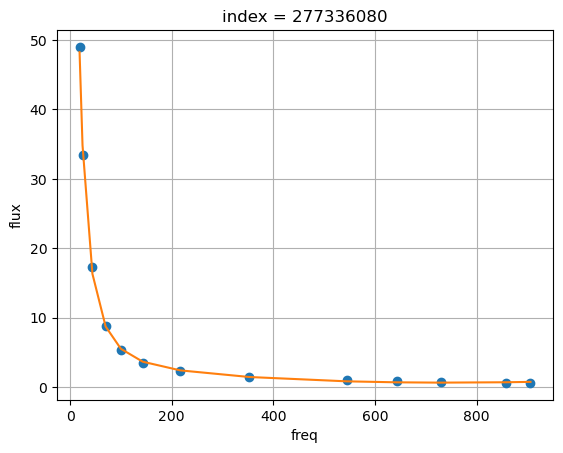

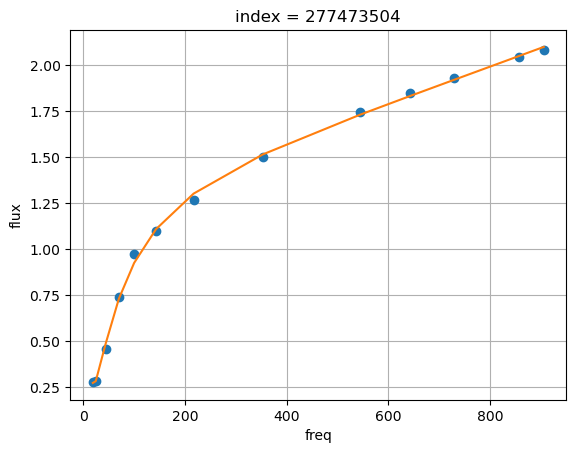

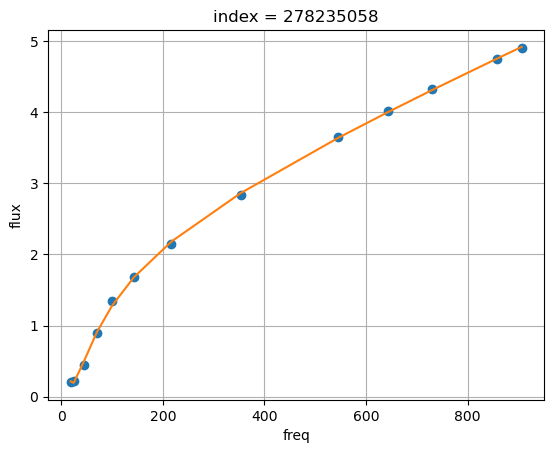

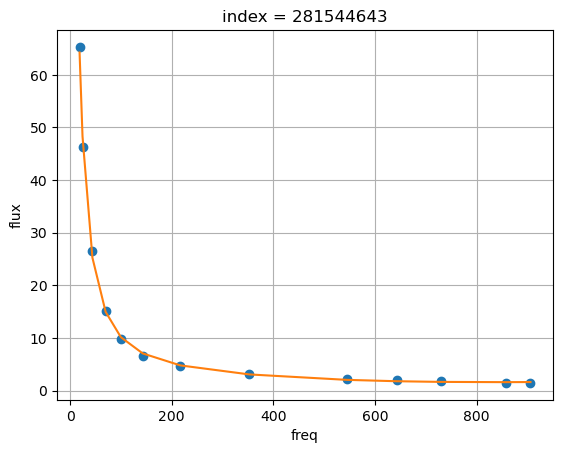

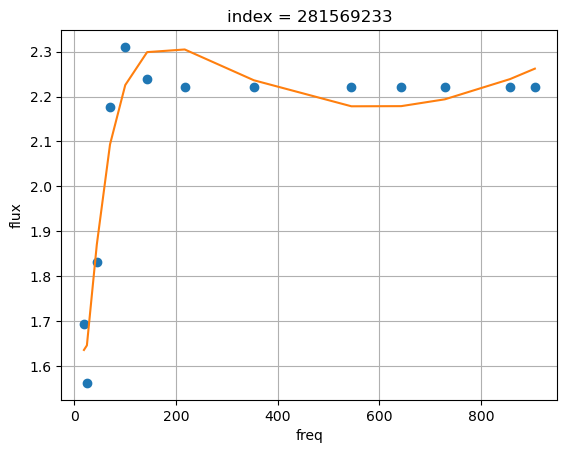

In [45]:
for s in all_indices:
    plt.figure()
    sources_xr.flux.sel(index=s).plot(marker="o", linestyle='none')#, xscale="log")
    plt.plot(sources_xr.coords["freq"], model(sources_xr.coords["freq"], *sources_xr.logpolycoef.sel(index=s)))
    plt.grid();

/tmp/ipykernel_1111920/2838928911.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


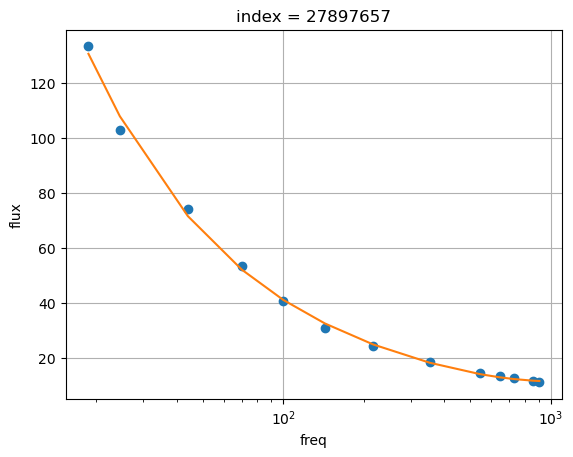

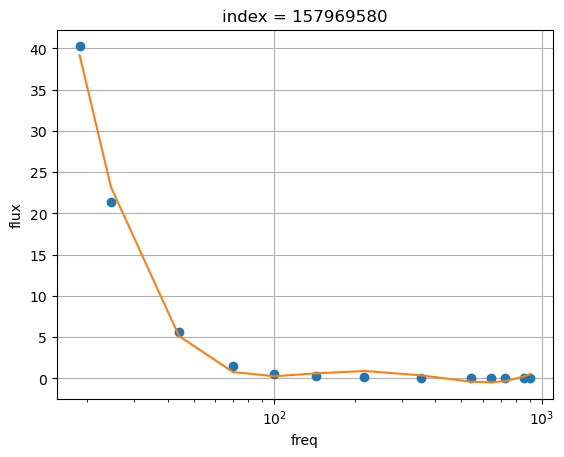

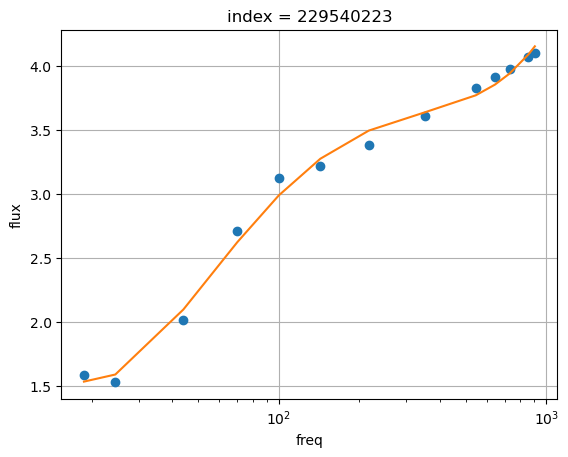

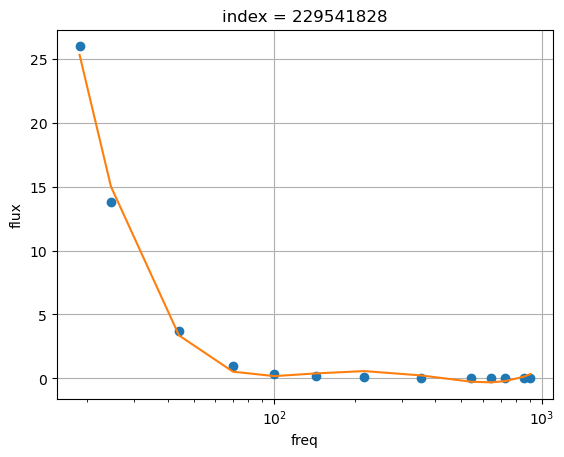

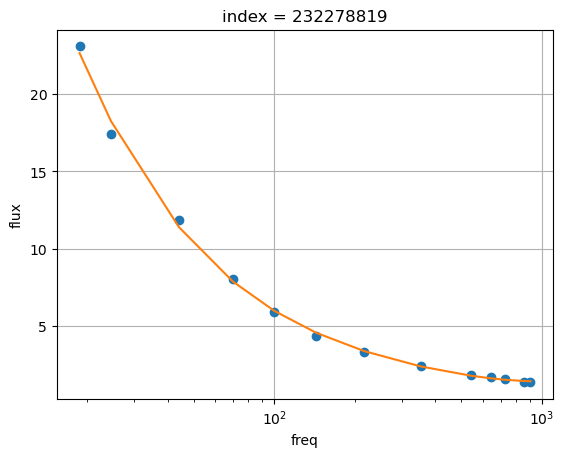

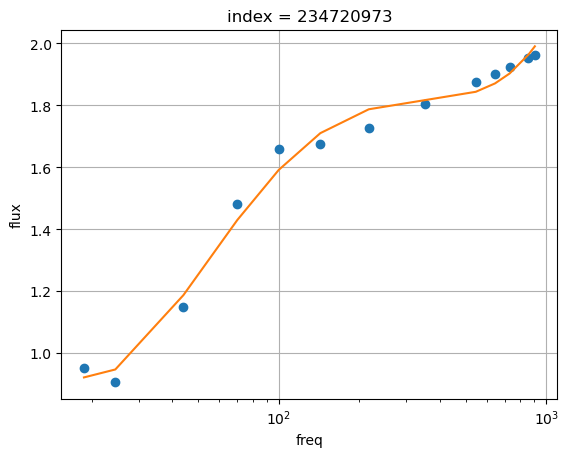

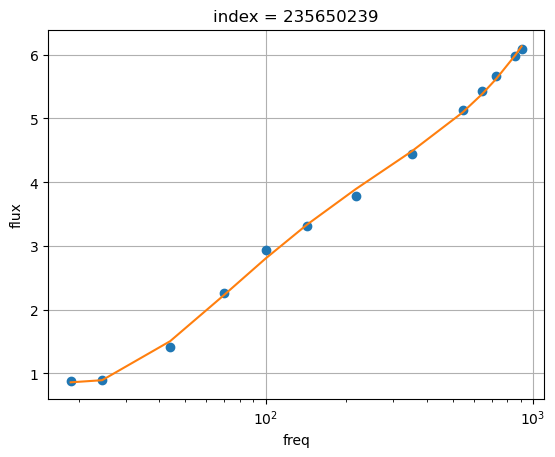

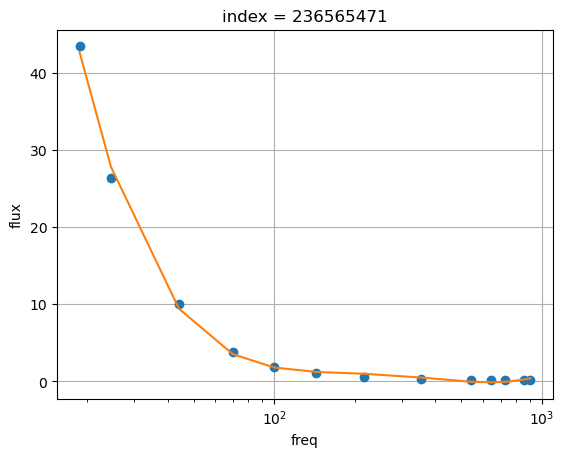

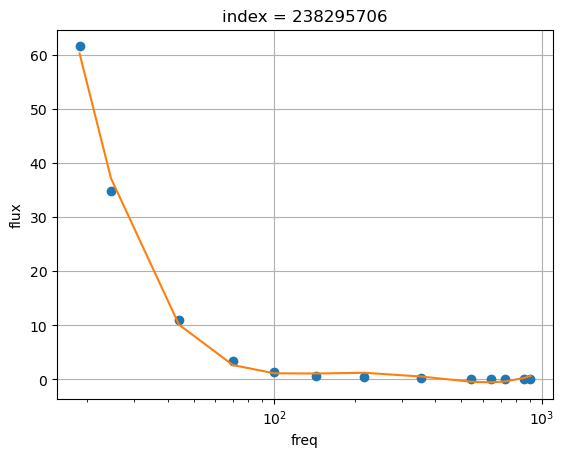

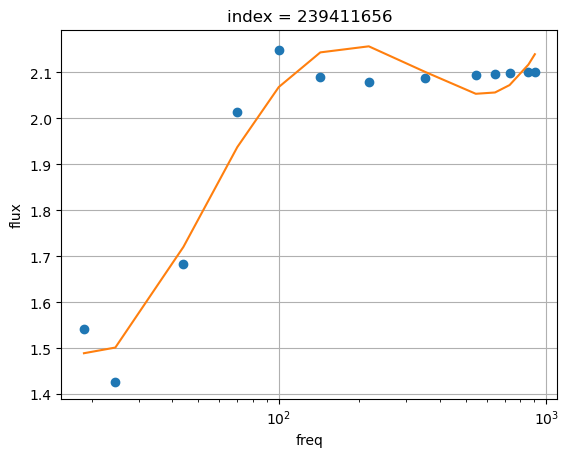

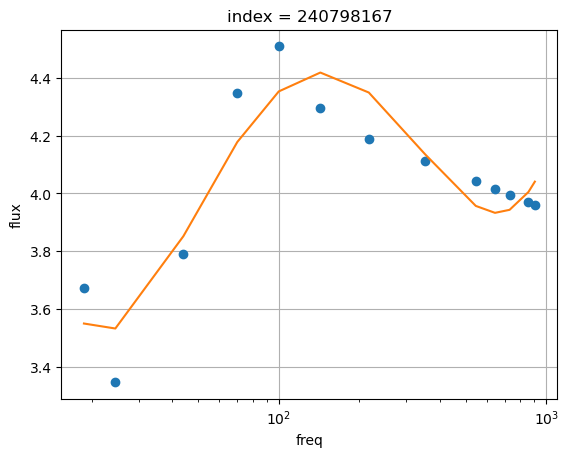

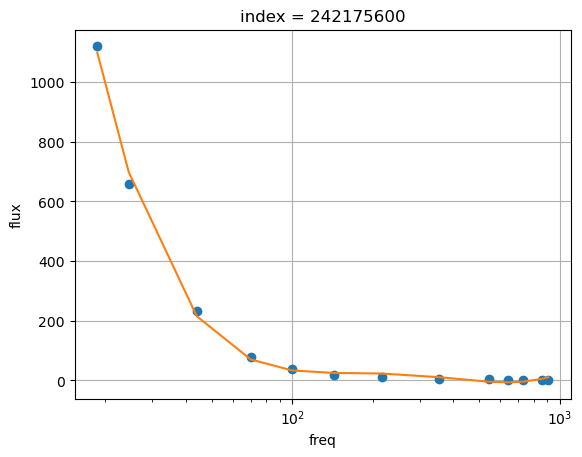

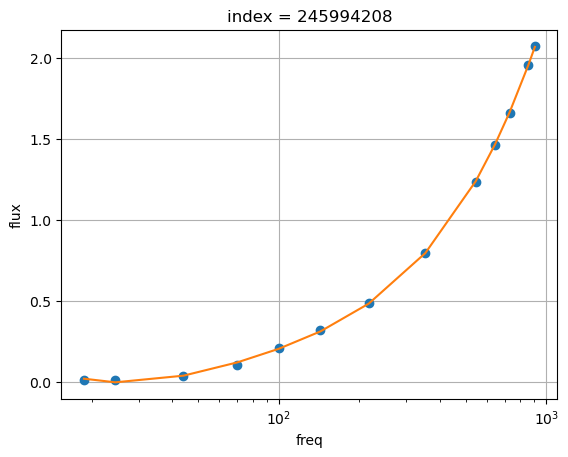

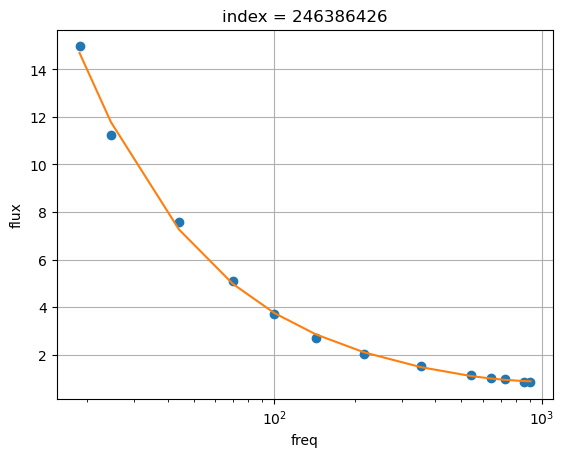

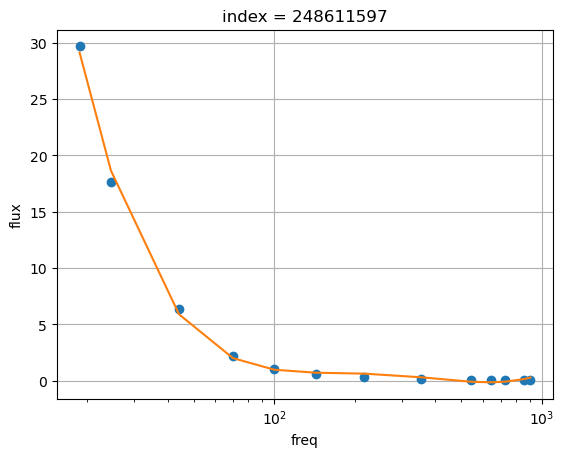

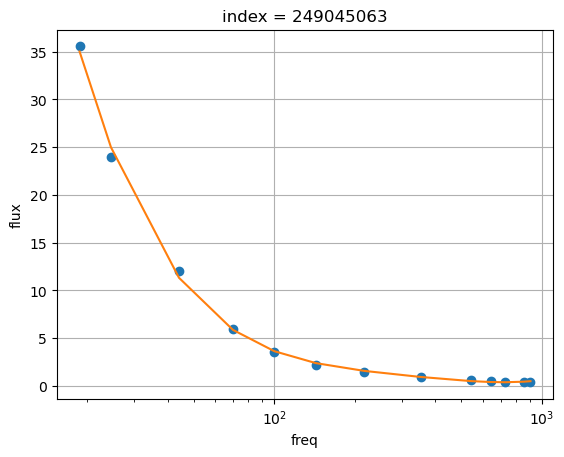

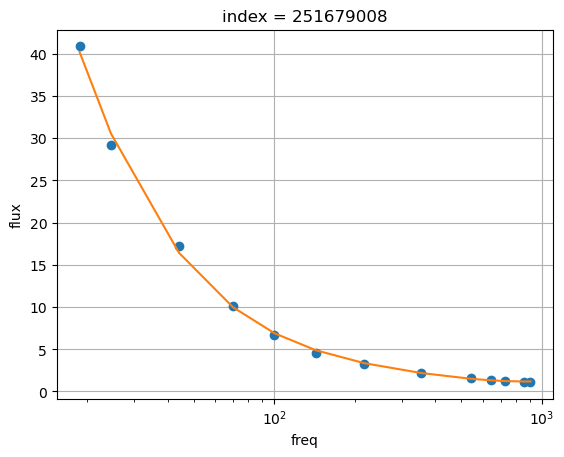

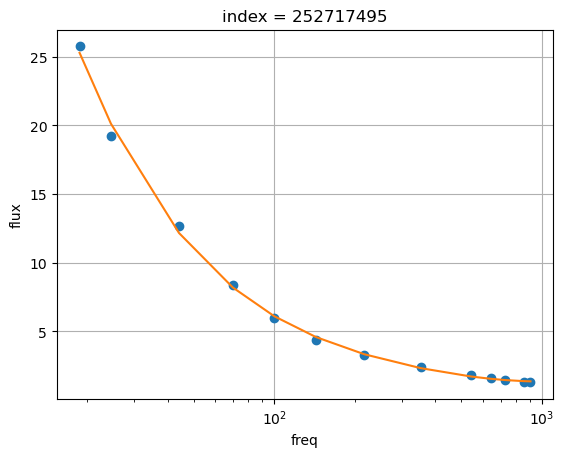

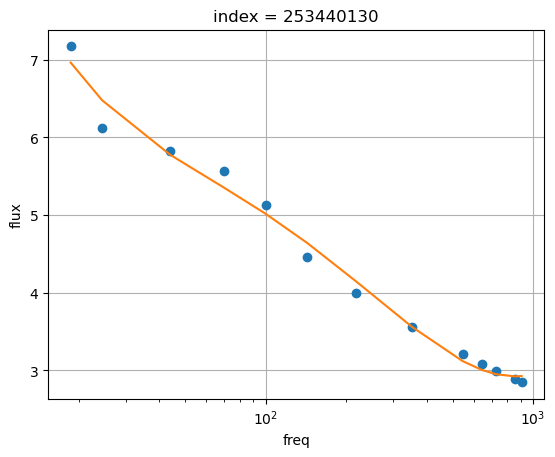

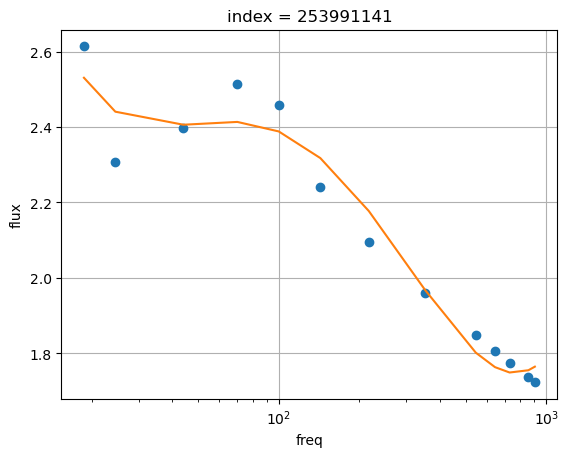

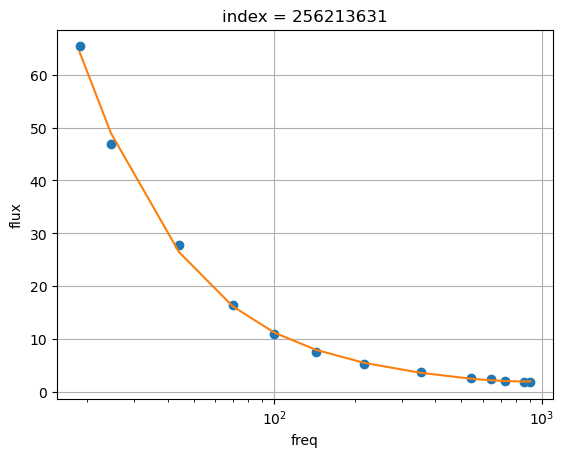

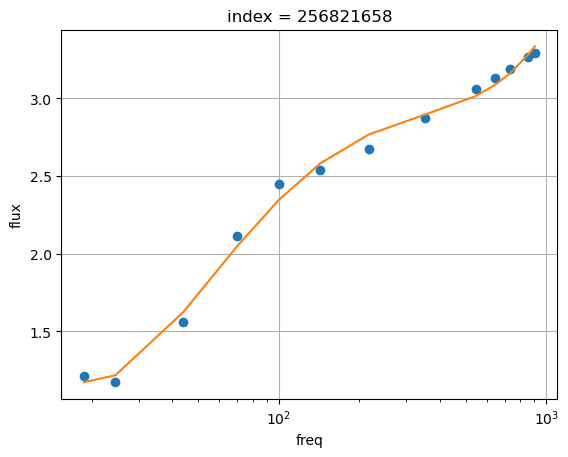

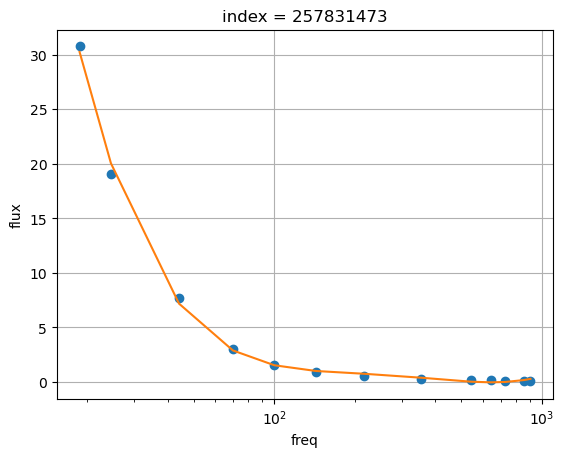

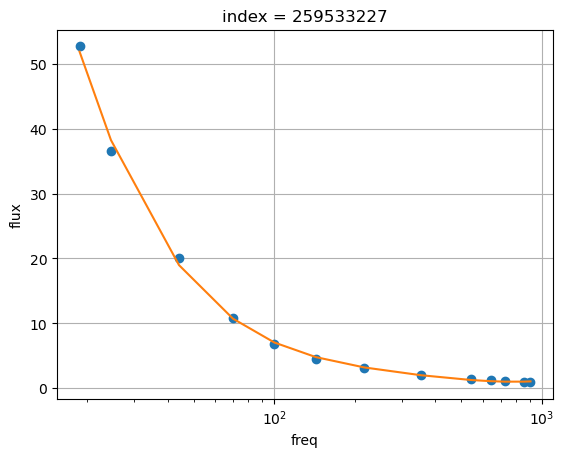

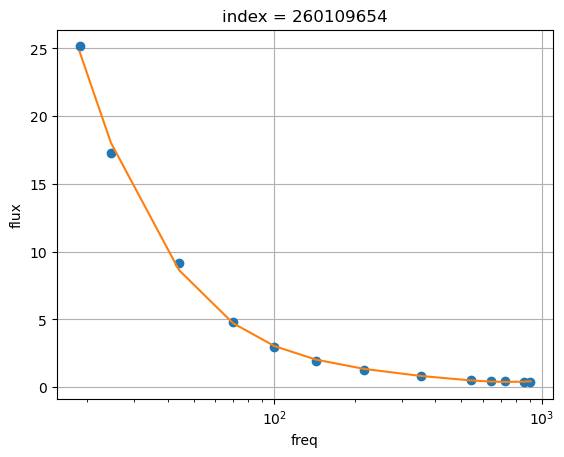

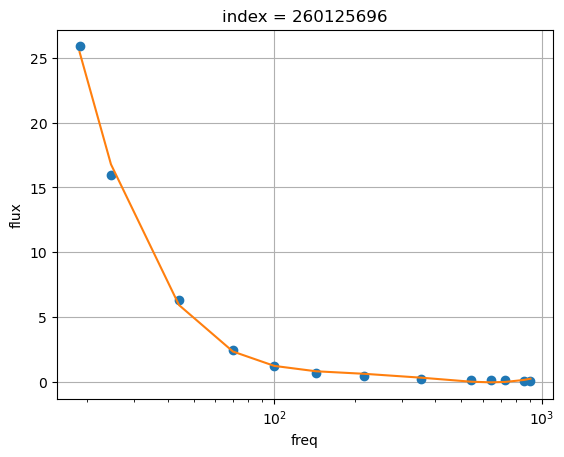

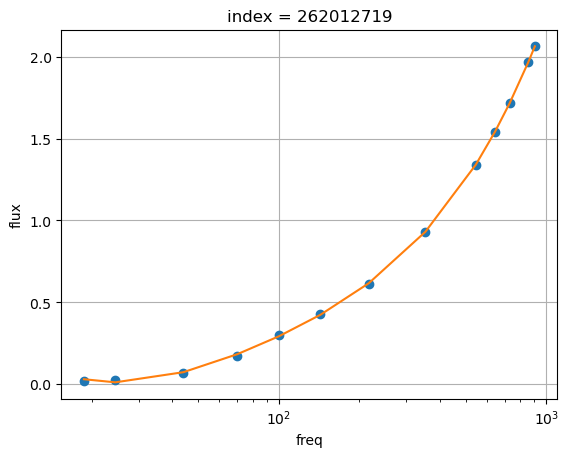

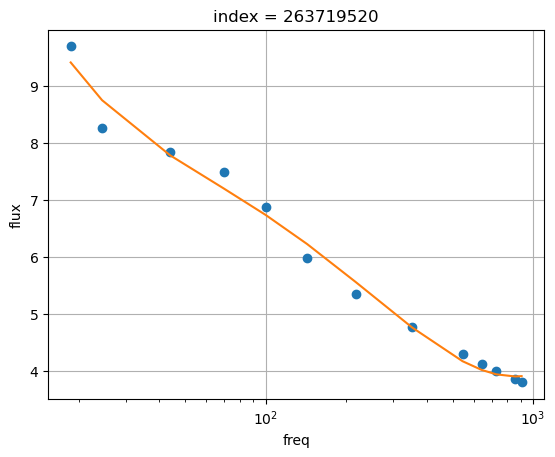

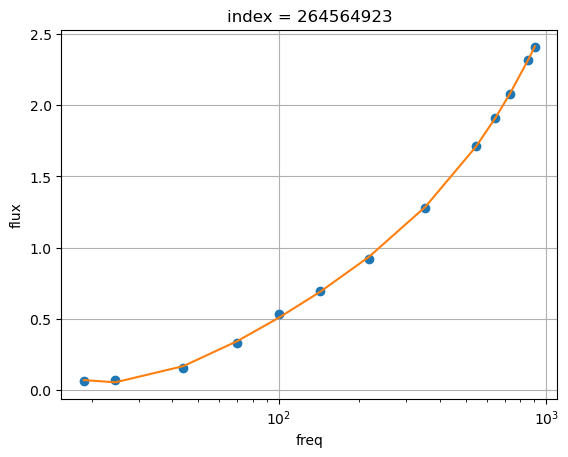

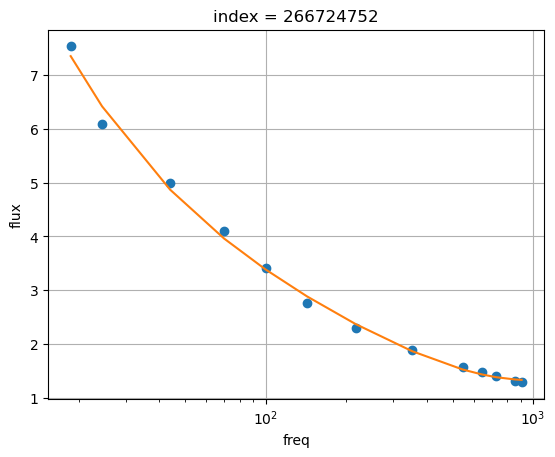

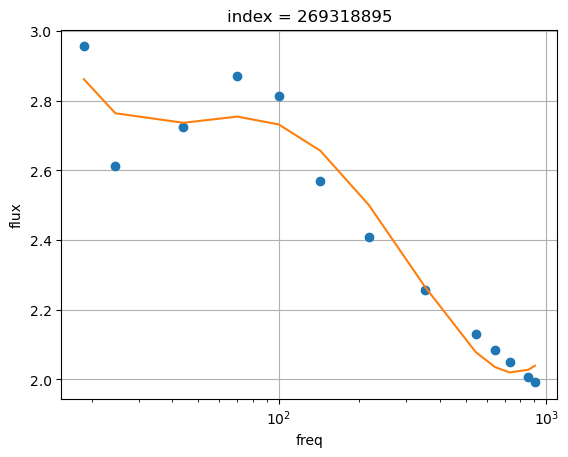

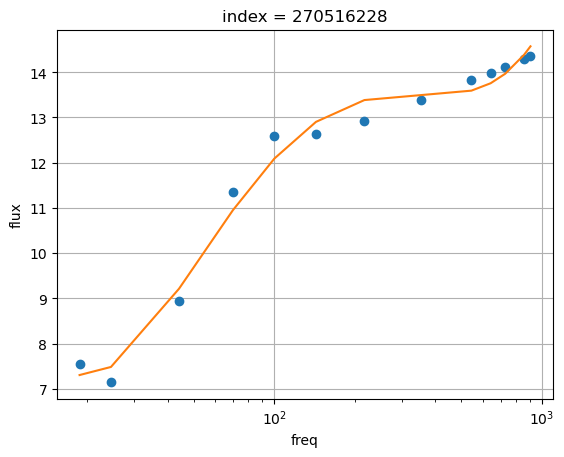

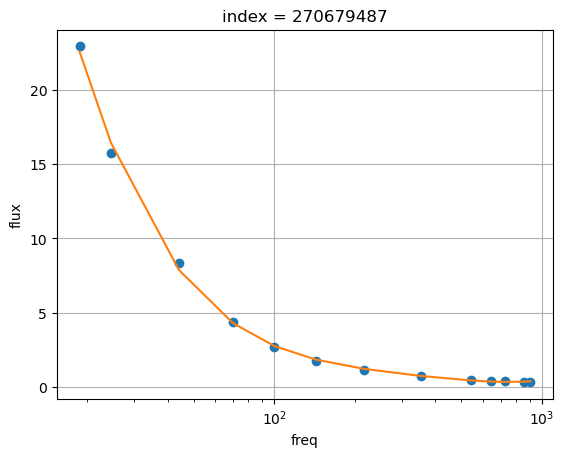

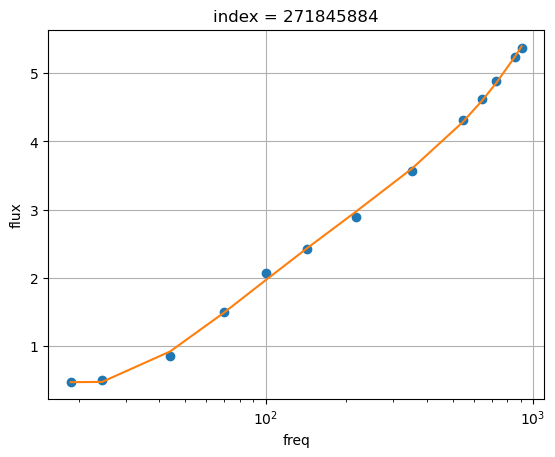

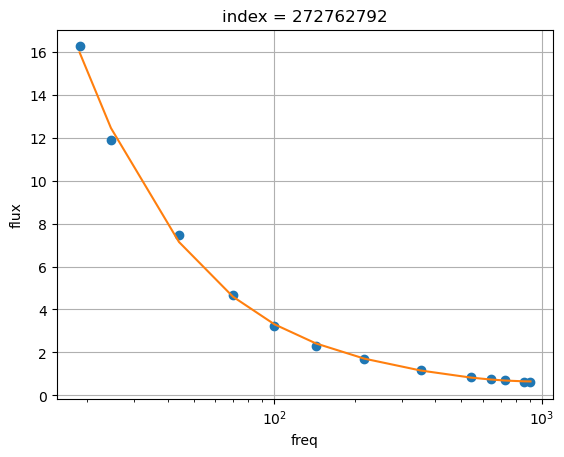

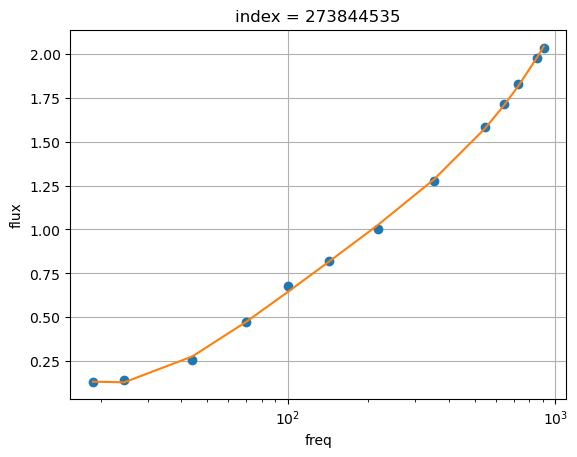

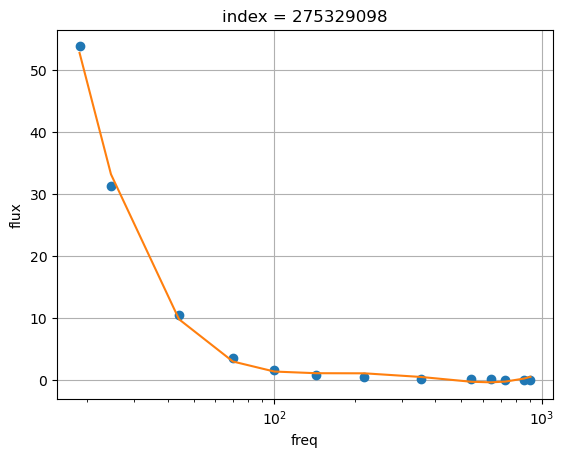

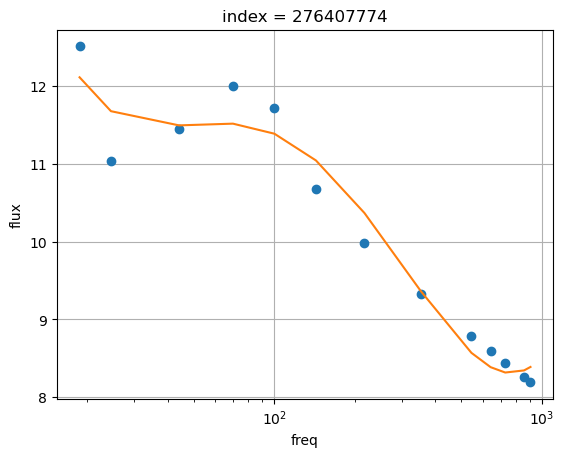

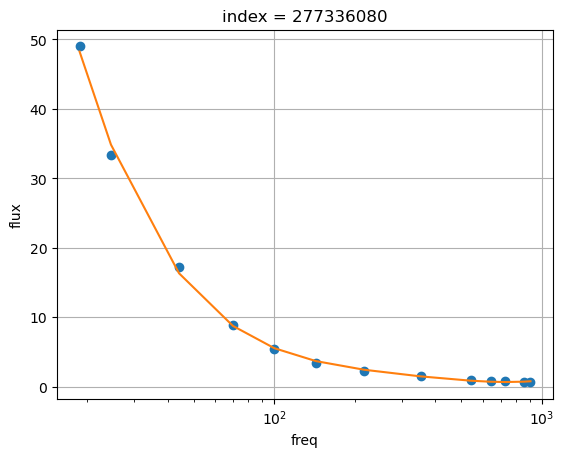

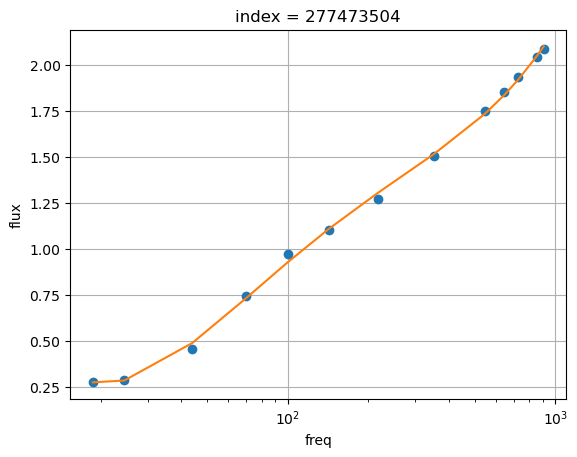

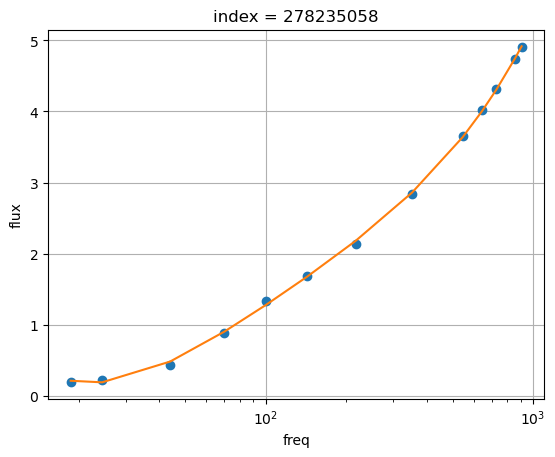

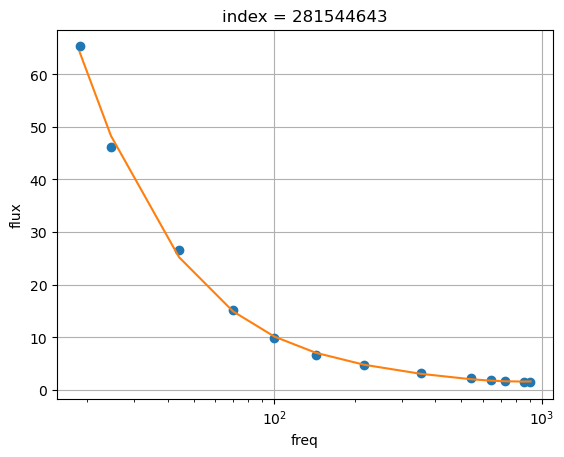

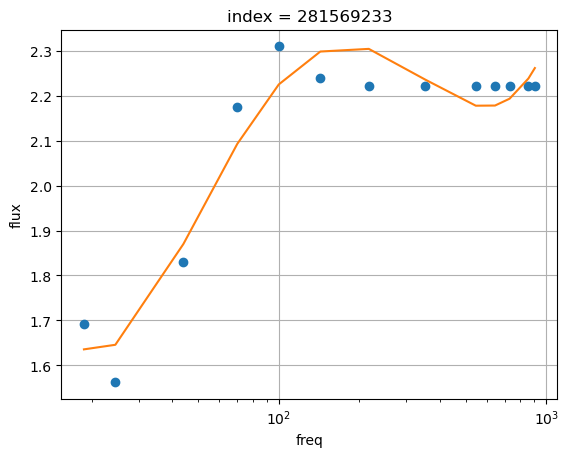

In [46]:
for s in all_indices:
    plt.figure()
    sources_xr.flux.sel(index=s).plot(marker="o", linestyle='none', xscale="log")
    plt.plot(sources_xr.coords["freq"], model(sources_xr.coords["freq"], *sources_xr.logpolycoef.sel(index=s)))
    plt.grid();